![techCompanies](tech_salaries_analysis.jpg) 

# Introduction
In a world where a cheeseburger no longer costs a quarter, or the even more dejecting reality that less and less of the affluent can afford personal yachts, the value of the dollar has become less and more concurrently.  Less valuable, because the purchasing power of the dollar has diminished, but more valuable because it is more important than ever to squeeze each dollar out of income sources.  In order to combat this reality, and add to the wealth of knowledge surrounding potentially increasing an individual’s income, we are analyzing the tech companies salary dataset.

This dataset consists of information corresponding to individuals with technology centered careers. The data includes general demographic information about the individual, such as education level, years of experience, sex, and race.  For income data, the dataset provides values for metrics such as base salary and total yearly compensation.  Examples of company level information provided include the name of the company and position.  
We will also be merging the dataset with a dataset of current stock market statistics.  This will focus our population on United States based public companies, which in turn will create a more accurate and useful model. This dataset will allow us to analyze variables like the market cap group, a categorical grouping of companies based on the number of outstanding shares multiplied by the stock price.  Other metrics include the number of employees currently employed by the company, the revenue per employee generated, the industry of the company, the sector of the company, and debt growth year over year.

# Objectives
The purpose of our exploration is to find what variables have an impact on tech centered career salaries, how strong the impact of those variables are, and make a prediction as to what salary an individual can potentially expect based on the value of variables that have an impact on salary.  The expectations of this analysis are that variables such as years of experience, market cap group, and revenue per employee have a strong influence on predicting the salary of an individual.

# Stakeholders
As for the stakeholders of our analysis, any individual, current or potential, looking to apply for tech related positions can use our analysis to focus their job search efforts using the metrics that have been found to be most effective in predicting salary to increase their potential salary.  This analysis can be bought or funded by companies similar to LinkedIn, who have a large stake in the analysis and trends of the job market. By gaining a better understanding of the driving factors of salaries, companies can implement initiatives to attract certain markets, ultimately contributing to the overall growth of the industry and the economy at large. 

# Research Questions
The main question we want to answer is what variables can influence the salary of an individual with a technology centered career in the United States.  Finding an answer to this question will give an individual the ability to tailor career decisions in a way to increase the probability of receiving a higher level of compensation.  We expect that the most influential factors include the years of experience an individual has, the size of the company they are working in, and the revenue generated by the company.  This will be analyzed through correlation statistics throughout the data analysis process.

We would like to also answer the question of how strong of a relationship do significant variables have in predicting one’s income within technology centric careers based in the United States.  We expect years of experience to have the largest impact in predicting one’s income.  In order to test this hypothesis, we will be looking at the correlation statistics between years of experience and base salary, as well as the value of the calculated coefficient of years of experience in a multivariate linear regression model.


![processing](data_processing.png) 

In [347]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import copy, math
from Matts_Utils import standardize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [348]:
def adj_r2_score(x, y, y_pred):
    n = len(y)
    p = x.shape[1]
    r = 1 - (1 - r2_score(y, y_pred)) * ((n-1) / (n - p - 1))
    
    return r

In [349]:
# Load the dataset
df = pd.read_csv('tech_companies_salary.csv')
df.shape

(62642, 29)

In [350]:
df.head(3)

timestamp company level              title  totalyearlycompensation  \
0  06-07-2017 11:33  Oracle    L3    Product Manager                   127000   
1  06-10-2017 17:11    eBay  SE 2  Software Engineer                   100000   
2  06-11-2017 14:53  Amazon    L7    Product Manager                   310000   

            location  yearsofexperience  yearsatcompany  tag  basesalary  ...  \
0   Redwood City, CA                1.5             1.5  NaN      107000  ...   
1  San Francisco, CA                5.0             3.0  NaN           0  ...   
2        Seattle, WA                8.0             0.0  NaN      155000  ...   

   Doctorate_Degree  Highschool Some_College Race_Asian  Race_White  \
0                 0           0            0          0           0   
1                 0           0            0          0           0   
2                 0           0            0          0           0   

   Race_Two_Or_More  Race_Black  Race_Hispanic  Race  Education  
0                 0           0              0   NaN        NaN  
1                 0           0              0   NaN        NaN  
2                 0           0              0   NaN        NaN  

[3 rows x 29 columns]

In [351]:
# Number of null values in each column
df.isna().sum()

timestamp                      0
company                        5
level                        123
title                          0
totalyearlycompensation        0
location                       0
yearsofexperience              0
yearsatcompany                 0
tag                          870
basesalary                     0
stockgrantvalue                0
bonus                          0
gender                     19540
otherdetails               22508
cityid                         0
dmaid                          2
rowNumber                      0
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0
Race_White                     0
Race_Two_Or_More               0
Race_Black                     0
Race_Hispanic                  0
Race                       40215
Education                  32272
dtype: int64

### Dropping categorical data with null values

>Dropping the data with null values in the gender, education, company, race, tag, and level columns, cleans up the data in order to look at the relationship of these variables on salaries.  

>These values cannot be replaced without adversely affecting other category values.

In [352]:
# Remove rows with null values in subset columns
df = df.dropna(subset=['gender', 'Education', 'company', 'Race', 'tag', 'level'])
df.shape

(21515, 29)

## Function to split the location column into city and state columns.

Locations with more than 2 strings delimited by a comma will be set to null values.  These locations correspond to locations outside of the United States.

Limiting our scope of the data to within the U.S. will increase the accuracy and usefulness of our model, as well as eliminate some outliers in the data.

In [353]:
def split_location(loc):
    location = loc.split(', ')  
    if len(location) == 2:
        city = location[0]
        state = location[1]
    else:
        city = None
        state = None
    return pd.Series([city, state])

# apply function to dataframe
df[['City', 'State']] = df['location'].apply(split_location)
# Remove rows with null values in State column
df = df.dropna(subset='State')

### Verification of Categorical Values

In [354]:
df.State.unique()

array(['CA', 'WA', 'TX', 'AZ', 'NY', 'IL', 'MA', 'NC', 'VA', 'CO', 'FL',
       'WI', 'DC', 'OR', 'MI', 'MN', 'MO', 'PA', 'UT', 'NJ', 'TN', 'LA',
       'GA', 'AR', 'IA', 'OH', 'MD', 'IN', 'MT', 'RI', 'DE', 'OK', 'NV',
       'CT', 'AL', 'SC', 'KS', 'KY', 'WV', 'MS', 'ID', 'NE', 'HI', 'NH',
       'NM', 'ND', 'VT', 'WY', 'ME'], dtype=object)

In [355]:
df.Education.unique()

array(['PhD', "Bachelor's Degree", "Master's Degree", 'Some College',
       'Highschool'], dtype=object)

In [356]:
df.Race.unique()

array(['Asian', 'Two Or More', 'White', 'Hispanic', 'Black'], dtype=object)

In [357]:
df.title.unique()

array(['Software Engineer', 'Software Engineering Manager',
       'Hardware Engineer', 'Product Designer', 'Management Consultant',
       'Product Manager', 'Solution Architect', 'Sales',
       'Technical Program Manager', 'Data Scientist', 'Recruiter',
       'Mechanical Engineer', 'Business Analyst', 'Human Resources',
       'Marketing'], dtype=object)

![stocks](stocks_data.png) 

In [358]:
stocks_df = pd.read_csv('screener-stocks.csv')
stocks_df.head(3)

Symbol                               Company Name    Market Cap  \
0   FLWS                          1-800-FLOWERS.COM  6.965698e+08   
1   VCXB  10X Capital Venture Acquisition Corp. III  1.421026e+08   
2    TXG                               10x Genomics  4.316825e+09   

   Stock Price % Change                     Industry  PE Ratio    Ent. Value  \
0        10.92    1.11%             Specialty Retail       NaN  7.024748e+08   
1        10.77      NaN              Shell Companies     63.35  1.420773e+08   
2        36.89    1.77%  Health Information Services       NaN  4.023500e+09   

    MC Group                  Sector  ...  Oper. Margin Pretax Margin  \
0  Small-Cap  Consumer Discretionary  ...        -2.89%        -3.39%   
1  Micro-Cap              Financials  ...           NaN           NaN   
2    Mid-Cap              Healthcare  ...       -42.88%       -40.21%   

  Profit Margin  R&D / Rev  Avg. Volume Rel. Volume    RSI Tax / Revenue  \
0        -3.24%      3.20%     420598.0      77.96%  59.81        -0.15%   
1           NaN        NaN      10038.0       0.12%  60.96           NaN   
2       -41.23%     43.69%    1403080.0      74.62%  34.24         1.02%   

  Rev Gr. This Q  Rev Gr. Next Q  
0         -5.95%          -3.19%  
1            NaN             NaN  
2          7.41%           8.17%  

[3 rows x 71 columns]

In [359]:
# Reformatting company values to uppercase representation eliminates redundant values in the tech salaries datase
# This also provides a category for a merge of both datasets
df['company'] = df['company'].apply(lambda company: company.upper())
stocks_df['company'] = stocks_df['Company Name'].apply(lambda company: company.upper())

#Removal of the reference to ticker GOOGL, in order to merge data corresponding solely on ticker symbol GOOG.
stocks_df.drop(stocks_df.loc[stocks_df['Symbol']=='GOOGL'].index, inplace=True)

### Editing Company Names
>Here we are reassigning many of the most common company names in the tech salaries dataset.

>These values are being changed to a value that aligns with the company names in the screener stock dataset.

In [360]:
df.loc[ df['company'] == 'GOOGLE', 'company'] = 'ALPHABET'
df.loc[ df['company'] == 'AMAZON', 'company'] = 'AMAZON.COM'
df.loc[ df['company'] == 'FACEBOOK', 'company'] = 'META PLATFORMS'
df.loc[ df['company'] == 'PAYPAL', 'company'] = 'PAYPAL HOLDINGS'
df.loc[ df['company'] == 'HSBC', 'company'] = 'HSBC HOLDINGS'
df.loc[ df['company'] == 'APPLE INC.', 'company'] = 'APPLE'
df.loc[ df['company'] == '2U', 'company'] = '2U, INC.'
df.loc[ df['company'] == 'ABBOTT', 'company'] = 'ABBOTT LABORATORIES'
df.loc[ df['company'] == '8X8', 'company'] = '8X8, INC.'
df.loc[ df['company'] == 'ADP', 'company'] = 'Automatic Data Processing'.upper()
df.loc[ df['company'] == 'AFFIRM', 'company'] = 'AFFIRM HOLDINGS'
df.loc[ df['company'] == 'AMD', 'company'] = 'ADVANCED MICRO DEVICES'
df.loc[ df['company'] == 'INTEL CORPORATION', 'company'] = 'INTEL'
df.loc[ df['company'] == 'IBM', 'company'] = 'INTERNATIONAL BUSINESS MACHINES'
df.loc[ df['company'] == 'CAPITAL ONE', 'company'] = 'CAPITAL ONE FINANCIAL'
df.loc[ df['company'] == 'CISCO', 'company'] = 'CISCO SYSTEMS'
df.loc[ df['company'] == 'JPMORGAN CHASE', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'JP MORGAN CHASE', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'JP MORGAN', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'UBER', 'company'] = 'UBER TECHNOLOGIES'
df.loc[ df['company'] == 'GOLDMAN SACHS', 'company'] = 'THE GOLDMAN SACHS GROUP'
df.loc[ df['company'] == 'WALMART LABS', 'company'] = 'WALMART'
df.loc[ df['company'] == 'EBAY', 'company'] = 'EBAY INC.'
df.loc[ df['company'] == 'VISA', 'company'] = 'VISA INC.'
df.loc[ df['company'] == 'LYFT', 'company'] = 'LYFT, INC.'
df.loc[ df['company'] == 'SAP', 'company'] = 'SAP SE'
df.loc[ df['company'] == 'DELL', 'company'] = 'DELL TECHNOLOGIES'
df.loc[ df['company'] == 'BOEING', 'company'] = 'THE BOEING COMPANY'
df.loc[ df['company'] == 'GENERAL MOTORS', 'company'] = 'GENERAL MOTORS COMPANY'
df.loc[ df['company'] == 'T-MOBILE', 'company'] = 'T-MOBILE US'

### Initial merge of the data sets

In [361]:
agg_df = pd.merge(df, stocks_df, on="company", how="left")


counts = agg_df['company'].value_counts()
print('Top 10 companies with the most representation: \n')
print(counts.head(10))
print('\nSymbol column nulls: ' + str(agg_df['Symbol'].isna().sum()))

Top 10 companies with the most representation: 

company
AMAZON.COM                         2090
MICROSOFT                          1299
ALPHABET                           1104
META PLATFORMS                      867
APPLE                               569
ORACLE                              309
INTEL                               303
INTERNATIONAL BUSINESS MACHINES     277
CAPITAL ONE FINANCIAL               267
CISCO SYSTEMS                       262
Name: count, dtype: int64

Symbol column nulls: 5093


### Eliminating Remaining Null Values

To eliminate the remaining null values of the symbol column, the entries were researched and a symbol was manually entered into the dataset. 
> Private companies were assigned "PRIVATE"

> Public companies only traded on international exchanges were assigned "INTERNATIONAL"

> Government operated companies were left null

> Remaining ambiguous companies were left null

> Subsidiaries were assigned the ticker symbol corresponding to their respective parent company.

These categories will be dropped from our analysis to focus the scope of our population.

This dataset was then merged on the "Symbol" column to fill in missing values and the dataset was saved as final_aggregated_df.csv.

Column names were updated in order to follow a uniform naming convention.

# Import of Aggregated Dataset

In [362]:
df = pd.read_csv('final_aggregated_df.csv')
df.head(3)

Unnamed: 0.1  Unnamed: 0  total_yearly_compensation  base_salary  bonus  \
0          5928           0                     400000       210000  45000   
1         10063           1                     136000       124000  11000   
2          5929           2                     337000       177000  36000   

     company  city_id       location state       city  ... pretax_margin  \
0   ALPHABET     7472  Sunnyvale, CA    CA  Sunnyvale  ...        27.89%   
1  MICROSOFT    11521    Redmond, WA    WA    Redmond  ...        44.47%   
2   ALPHABET     7413  San Bruno, CA    CA  San Bruno  ...        27.89%   

  profit_margin research_development_over_revenue  average_volume  \
0        24.01%                            14.78%      22956359.0   
1        36.27%                            12.09%      22842031.0   
2        24.01%                            14.78%      22956359.0   

   relative_volume    rsi  tax_over_revenue  revenue_growth_this_quarter  \
0           72.27%  64.81             3.88%                       16.00%   
1           72.63%  56.25             8.20%                       17.27%   
2           72.27%  64.81             3.88%                       16.00%   

  revenue_growth_next_quarter   sex  
0                      14.35%  Male  
1                      17.13%  Male  
2                      14.35%  Male  

[3 rows x 92 columns]

In [363]:
df.shape

(16903, 92)

In [364]:
# drop entries with null values in the symbol column removes ambiguous and government operated companies
df = df.dropna(subset='symbol')

# drop entries where symbol is international or private
public_companies = df[(df['symbol'] != 'INTERNATIONAL') & (df['symbol'] != 'PRIVATE')]
public_companies.shape

(14208, 92)

In [365]:
# Subsetting columns to be included in analysis
public_companies = public_companies[['base_salary', 'total_yearly_compensation', 'title', 'years_of_experience', 
                                     'years_at_company', 'education', 'race', 'sex', 'mc_group', 'sector', 
                                     'industry', 'employees', 'revenue_per_employee', 'profit_per_employee',
                                     'cash_over_market_cap', 'debt_growth_year_over_year', 'rsi']]

In [366]:
public_companies.head(3)

base_salary  total_yearly_compensation              title  \
0       210000                     400000  Software Engineer   
1       124000                     136000  Software Engineer   
2       177000                     337000  Software Engineer   

   years_of_experience  years_at_company          education         race  \
0                    5                 5                PhD        Asian   
1                    3                 2  Bachelor's Degree  Two Or More   
2                    6                 6  Bachelor's Degree        Asian   

    sex  mc_group                  sector                        industry  \
0  Male  Mega-Cap  Communication Services  Internet Content & Information   
1  Male  Mega-Cap              Technology       Software - Infrastructure   
2  Male  Mega-Cap  Communication Services  Internet Content & Information   

   employees  revenue_per_employee  profit_per_employee cash_over_market_cap  \
0   182381.0             1685450.0             404620.0                4.54%   
1   221000.0             1029787.0             373489.0               -0.23%   
2   182381.0             1685450.0             404620.0                4.54%   

  debt_growth_year_over_year    rsi  
0                     -5.47%  64.81  
1                     47.01%  56.25  
2                     -5.47%  64.81

In [367]:
public_companies.shape

(14208, 17)

![exploratory](exploratory.png) 

# Refining Variables

### In this section, we will be evaluating the variables we are using to predict base salary.  Our goal is to minimize the number of variables and maximize the effectiveness of the remaining variables.

In [368]:
#creating dataset with variables of interest
public_companies = public_companies[['base_salary', 'years_of_experience', 'employees', 'revenue_per_employee',
                                     'education', 'title', 'race', 'sex', 'mc_group', 'sector']]
public_companies.shape

(14208, 10)

>Profit per employee has a collinear relationship with revenue per employee.  Profit per employee is a function of revenue per employee and influenced by external factors like debt taken on by a company for the given year.  This makes it a less reliable predictor, therefore we are dropping it from the variables of interest.

>Years at company has a collinear relationship with years of experience, however years of experience is a more reliable metric due to its holistic nature.  It is for this reason we are dropping years at company from the variables of interest.

>RSI, or the relative strength index is a metric for evaluating if a stock is overbought or oversold.  This is a function of stock price and volume over time.  RSI is a time sensitive metric and with little direct relationship to predicting base salary, therefore we are dropping it from the dataset.

> Cash over market cap is a measure of the cash a company has on hand relative to the market cap of the stock.  The market cap is the number of outstanding shares times the stock price.  Because of the proportional property of this metric we are dropping it from the dataset in lieu of more direct variables like revenue per employee.

> Debt growth year over year is also a time sensitive metric.  Given that our dataset has entries dating back to 2016 and our stock market data is current, we have eliminated this from being a variable of interest.

In [369]:
public_companies.isna().sum()

base_salary              0
years_of_experience      0
employees               11
revenue_per_employee    32
education                0
title                    0
race                     0
sex                      0
mc_group                 0
sector                   0
dtype: int64

In [370]:
# drop nulls
public_companies = public_companies.dropna(subset=['employees', 'revenue_per_employee'])

# Data Standardization

In [371]:
# coloumns to be standardized
columns = ['base_salary', 'years_of_experience', 'employees', 'revenue_per_employee']

means = public_companies[columns].mean()
stds = public_companies[columns].std()

# Z-score standardization
for column in columns:
    public_companies[column + '_std'] = (public_companies[column] - means[column]) / stds[column]

In [372]:
# Make a copy for testing purposes before incoming reduction of data
public_companies_copy = public_companies

In [373]:
public_companies.head(3)

base_salary  years_of_experience  employees  revenue_per_employee  \
0       210000                    5   182381.0             1685450.0   
1       124000                    3   221000.0             1029787.0   
2       177000                    6   182381.0             1685450.0   

           education              title         race   sex  mc_group  \
0                PhD  Software Engineer        Asian  Male  Mega-Cap   
1  Bachelor's Degree  Software Engineer  Two Or More  Male  Mega-Cap   
2  Bachelor's Degree  Software Engineer        Asian  Male  Mega-Cap   

                   sector  base_salary_std  years_of_experience_std  \
0  Communication Services         1.204493                -0.382571   
1              Technology        -0.539148                -0.707955   
2  Communication Services         0.535421                -0.219880   

   employees_std  revenue_per_employee_std  
0      -0.307317                  0.830102  
1      -0.236781                  0.104547  
2      -0.307317                  0.830102

## Descriptive Statistics

In [374]:
public_companies.describe().round(2)

base_salary  years_of_experience  employees  revenue_per_employee  \
count     14176.00             14176.00    14176.0              14176.00   
mean     150591.92                 7.35   350641.0             935310.56   
std       49322.07                 6.15   547513.5             903671.35   
min       10000.00                 0.00        7.0              18387.00   
25%      120000.00                 3.00    29945.0             376908.00   
50%      146000.00                 6.00   124800.0             674122.00   
75%      171000.00                10.00   221000.0            1226349.00   
max      893000.00                45.00  2100000.0           25719571.00   

       base_salary_std  years_of_experience_std  employees_std  \
count         14176.00                 14176.00       14176.00   
mean             -0.00                    -0.00           0.00   
std               1.00                     1.00           1.00   
min              -2.85                    -1.20          -0.64   
25%              -0.62                    -0.71          -0.59   
50%              -0.09                    -0.22          -0.41   
75%               0.41                     0.43          -0.24   
max              15.05                     6.13           3.20   

       revenue_per_employee_std  
count                  14176.00  
mean                      -0.00  
std                        1.00  
min                       -1.01  
25%                       -0.62  
50%                       -0.29  
75%                        0.32  
max                       27.43

# Numerical Data: Summary Statistics and Visualizations

In [375]:
#Function to remove outliers based on IQR
def removeOutliersIQR(df, column):

    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)
    
    iqr = q3 - q1
    upperThreshold = q3 + (1.5 * iqr)
    lowerThreshold = q1 - (1.5 * iqr)
    
    df = df[(df[column] <= upperThreshold) & (df[column] >= lowerThreshold)]    
    
    return df

## Quantitative Individual Level Data

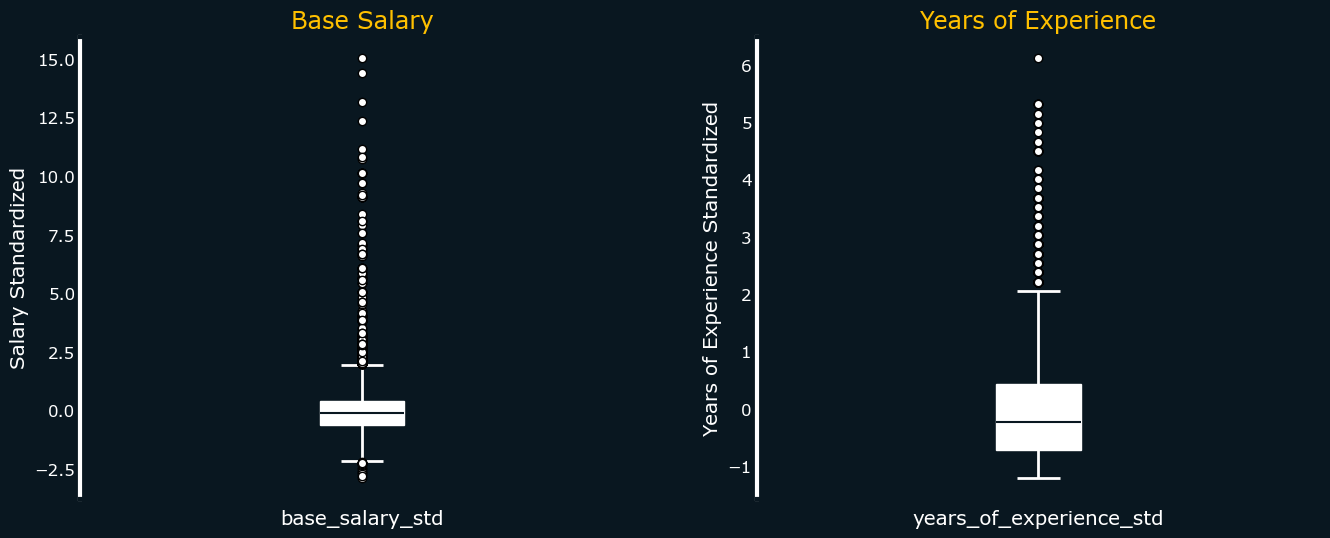

In [376]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

public_companies.boxplot(column='base_salary_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[0])
ax[0].set_title('Base Salary')
ax[0].spines['bottom'].set_color('#091720')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
fig.patch.set_facecolor('#091720')
ax[0].set_facecolor('#091720')
ax[0].set_title('Base Salary', color='#FFC000')
ax[0].set_xlabel("base_salary_std", color='white')
ax[0].set_ylabel("Salary Standardized", color='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].grid(visible=False)

public_companies.boxplot(column='years_of_experience_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[1])
ax[1].set_title('Years of Experience', color='#FFC000')
ax[1].spines['bottom'].set_color('#091720')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')
ax[1].set_xlabel("years_of_experience_std", color='white')
ax[1].set_ylabel("Years of Experience Standardized", color='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(visible=False)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

plt.show()

In [377]:
# remove outliers
public_companies = removeOutliersIQR(public_companies, 'base_salary_std')
public_companies = removeOutliersIQR(public_companies, 'years_of_experience_std')

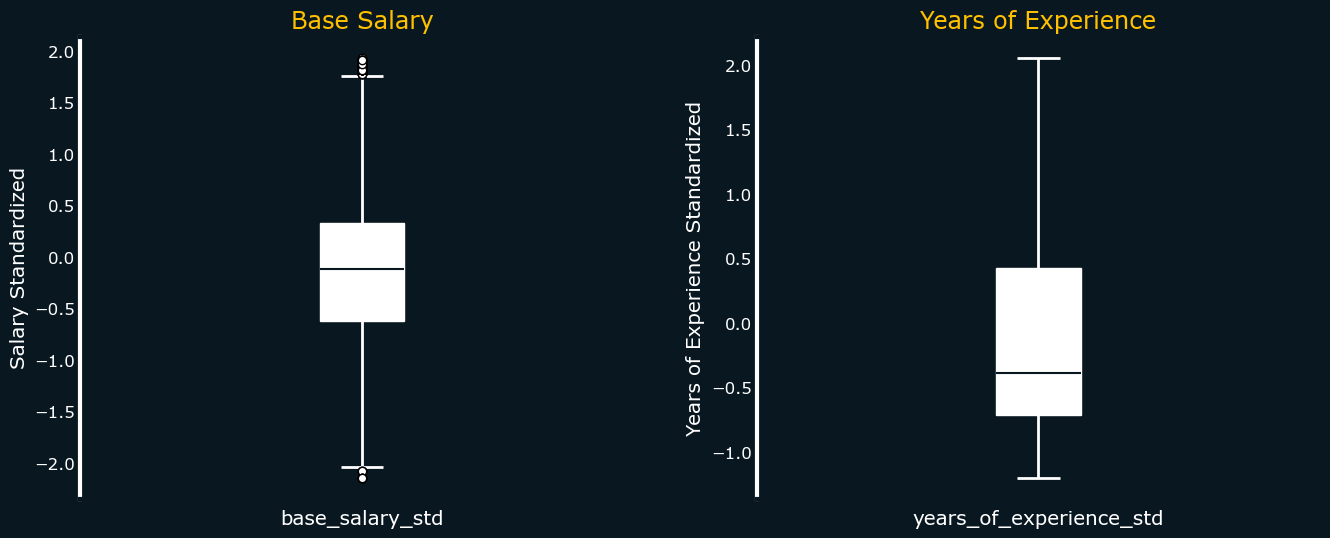

In [378]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

public_companies.boxplot(column='base_salary_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[0])
ax[0].set_title('Base Salary')
ax[0].spines['bottom'].set_color('#091720')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
fig.patch.set_facecolor('#091720')
ax[0].set_facecolor('#091720')
ax[0].set_title('Base Salary', color='#FFC000')
ax[0].set_xlabel("base_salary_std", color='white')
ax[0].set_ylabel("Salary Standardized", color='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].grid(visible=False)

public_companies.boxplot(column='years_of_experience_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[1])
ax[1].set_title('Years of Experience', color='#FFC000')
ax[1].spines['bottom'].set_color('#091720')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')
ax[1].set_xlabel("years_of_experience_std", color='white')
ax[1].set_ylabel("Years of Experience Standardized", color='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(visible=False)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

plt.show()

In [379]:
public_companies[['base_salary_std', 'years_of_experience_std']].describe()

base_salary_std  years_of_experience_std
count     13383.000000             13383.000000
mean         -0.114244                -0.122651
std           0.730099                 0.834791
min          -2.140865                -1.196031
25%          -0.620248                -0.707955
50%          -0.113376                -0.382571
75%           0.332672                 0.430888
max           1.934389                 2.057806

## Quantitative Company Level Data

In [380]:
public_companies.dropna(subset=['employees_std', 'revenue_per_employee_std'], inplace=True)

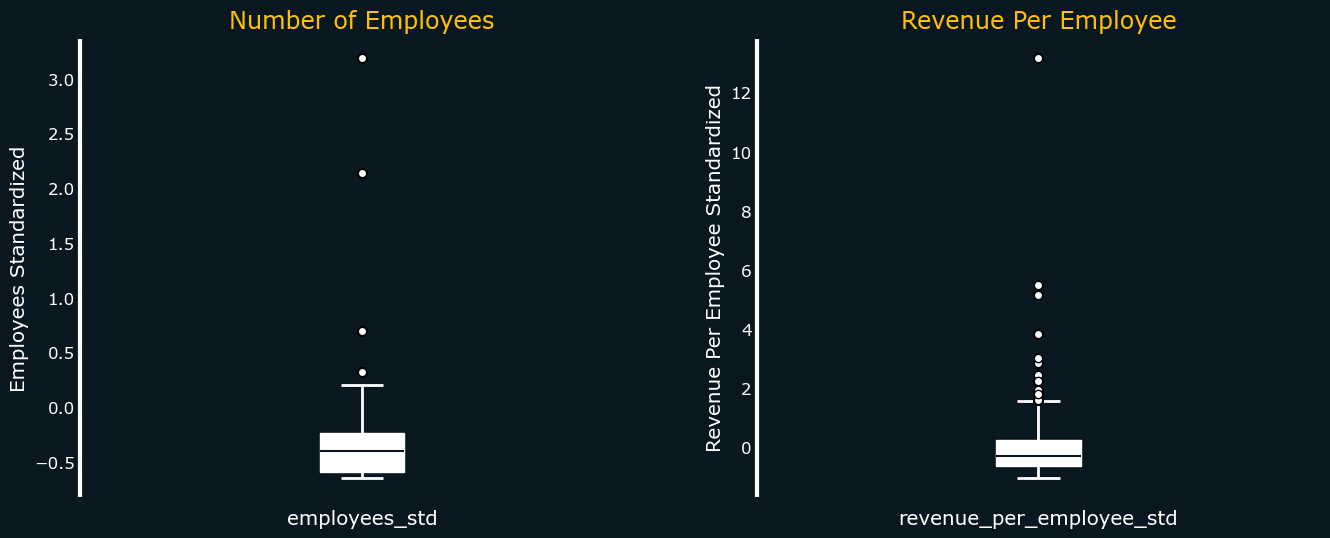

In [381]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

public_companies.boxplot(column='employees_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[0])
ax[0].spines['bottom'].set_color('#091720')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
fig.patch.set_facecolor('#091720')
ax[0].set_facecolor('#091720')
ax[0].set_title('Number of Employees', color='#FFC000')
ax[0].set_xlabel("employees_std", color='white')
ax[0].set_ylabel("Employees Standardized", color='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].grid(visible=False)

public_companies.boxplot(column='revenue_per_employee_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[1])
ax[1].set_title('Revenue Per Employee', color='#FFC000')
ax[1].spines['bottom'].set_color('#091720')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')
ax[1].set_xlabel("revenue_per_employee_std", color='white')
ax[1].set_ylabel("Revenue Per Employee Standardized", color='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(visible=False)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

plt.show()

In [382]:
#remove outliers
public_companies = removeOutliersIQR(public_companies, 'employees_std')
public_companies = removeOutliersIQR(public_companies, 'revenue_per_employee_std')

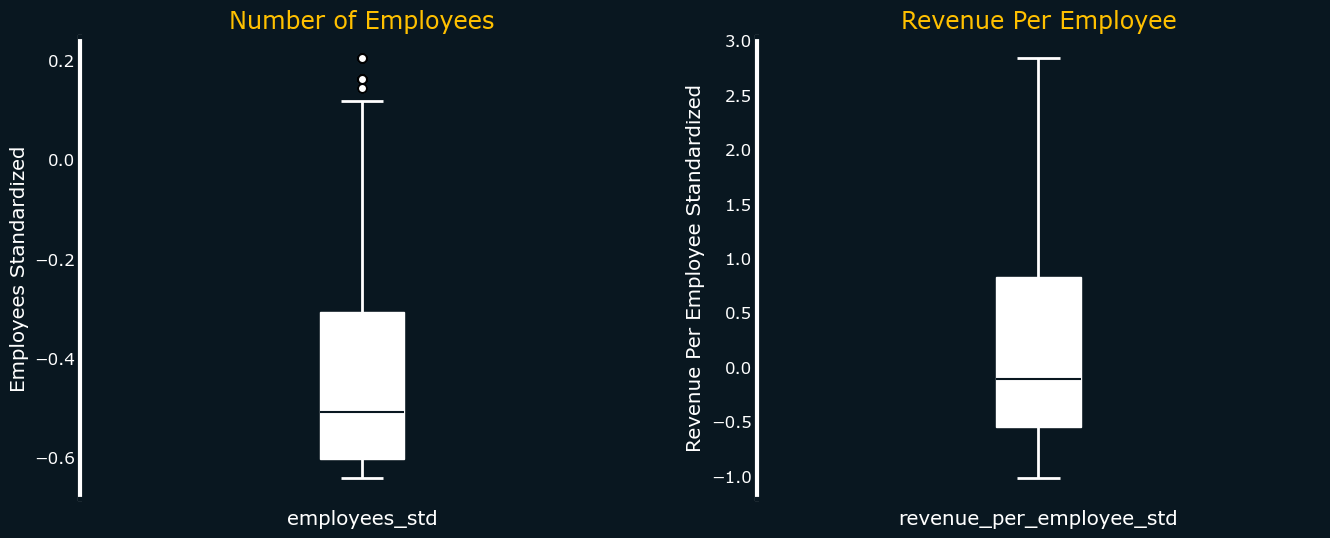

In [383]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

public_companies.boxplot(column='employees_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[0])
ax[0].spines['bottom'].set_color('#091720')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
fig.patch.set_facecolor('#091720')
ax[0].set_facecolor('#091720')
ax[0].set_title('Number of Employees', color='#FFC000')
ax[0].set_xlabel("employees_std", color='white')
ax[0].set_ylabel("Employees Standardized", color='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].grid(visible=False)

public_companies.boxplot(column='revenue_per_employee_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[1])
ax[1].set_title('Revenue Per Employee', color='#FFC000')
ax[1].spines['bottom'].set_color('#091720')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')
ax[1].set_xlabel("revenue_per_employee_std", color='white')
ax[1].set_ylabel("Revenue Per Employee Standardized", color='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(visible=False)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

plt.show()

In [384]:
public_companies[['employees_std', 'revenue_per_employee_std']].describe()

employees_std  revenue_per_employee_std
count   10961.000000              10961.000000
mean       -0.440944                  0.072302
std         0.171683                  0.720021
min        -0.640276                 -1.014665
25%        -0.603348                 -0.554174
50%        -0.507675                 -0.112617
75%        -0.307317                  0.830102
max         0.205400                  2.843103

# Categorical Data
## Individual Level

In [385]:
public_companies[['education', 'race', 'sex', 'title', 'mc_group', 'sector']].describe()

education   race    sex              title  mc_group  \
count               10961  10961  10961              10961     10961   
unique                  5      5      3                 15         6   
top     Bachelor's Degree  Asian   Male  Software Engineer  Mega-Cap   
freq                 5293   5728   8625               6918      5587   

            sector  
count        10961  
unique          11  
top     Technology  
freq          5714

In [386]:
public_companies.groupby('mc_group')['base_salary_std'].count()

mc_group
Large-Cap    4306
Mega-Cap     5587
Micro-Cap      27
Mid-Cap       802
Nano-Cap       22
Small-Cap     217
Name: base_salary_std, dtype: int64

In [387]:
public_companies.groupby('sector')['base_salary_std'].count()

sector
Communication Services    2508
Consumer Discretionary     790
Consumer Staples            79
Energy                       8
Financials                1219
Healthcare                 185
Industrials                415
Materials                    5
Real Estate                 32
Technology                5714
Utilities                    6
Name: base_salary_std, dtype: int64

In [388]:
# removing data entries belonging to categorwith less than 30 observations
public_companies = public_companies.drop(public_companies[public_companies['mc_group'] == 'Micro-Cap'].index)
public_companies = public_companies.drop(public_companies[public_companies['mc_group'] == 'Nano-Cap'].index)

public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Energy'].index)
public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Materials'].index)
public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Utilities'].index)

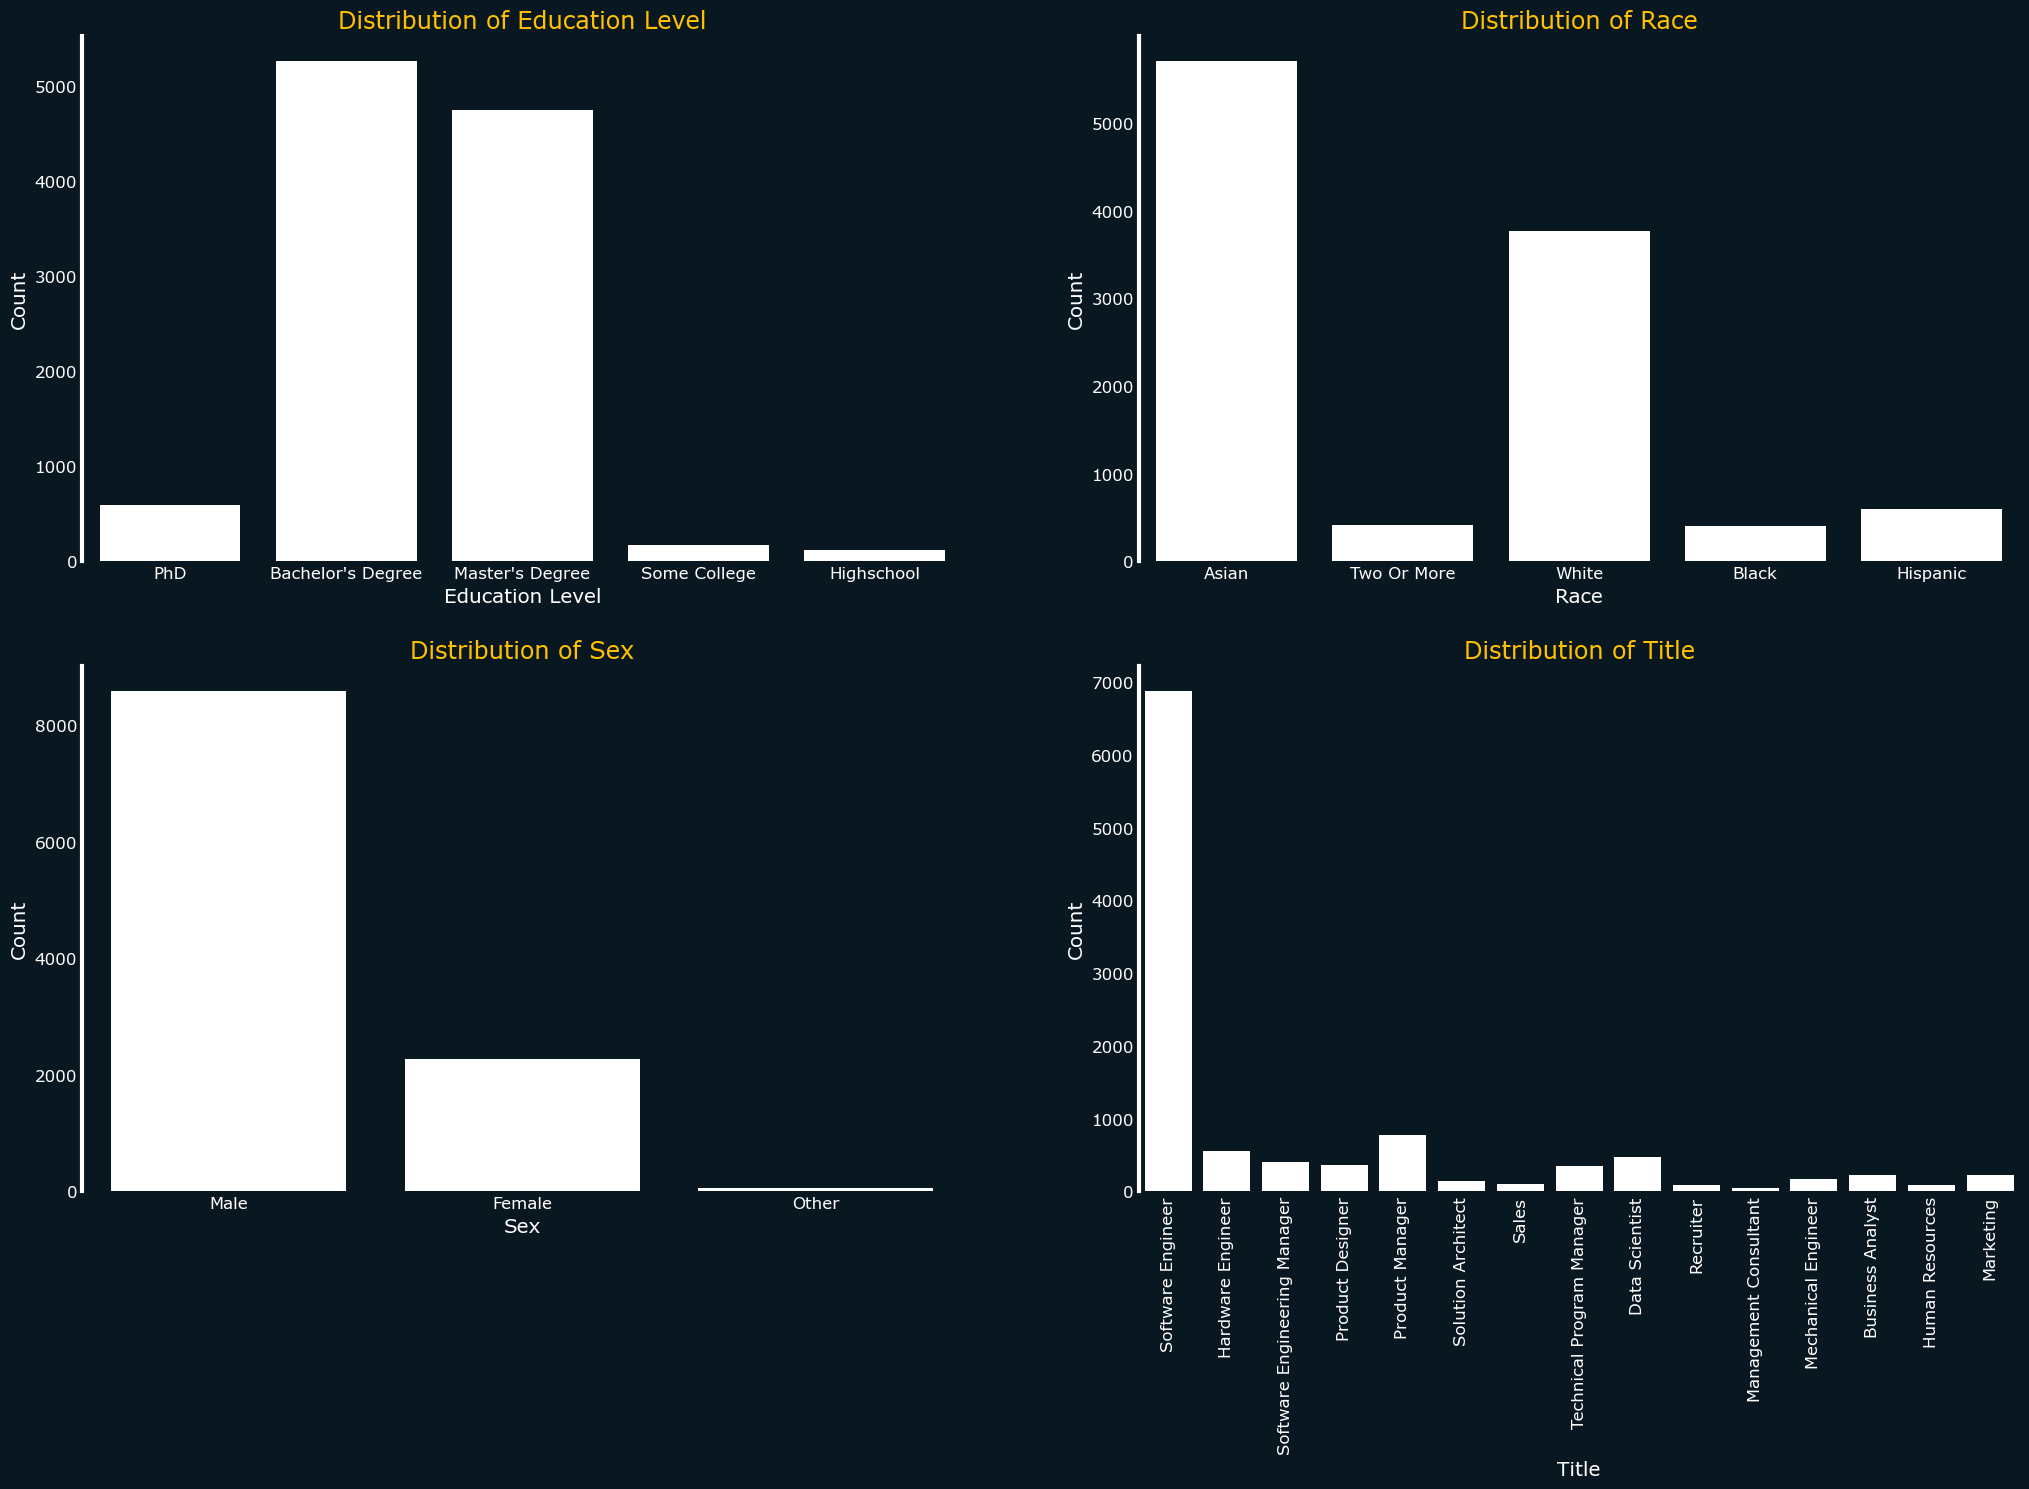

In [389]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='education', data=public_companies, color='white', ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Education Level', color='#FFC000')
ax[0, 0].set_ylabel('Count', color='white')
ax[0, 0].set_xlabel('Education Level', color='white')
ax[0, 0].set_facecolor('#091720')
ax[0, 0].tick_params(axis='y', colors='white')
ax[0, 0].tick_params(axis='x', colors='white')


ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['bottom'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_color('white')

sns.countplot(x='race', data=public_companies, color='white', ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Race', color='#FFC000')
ax[0, 1].set_ylabel('Count', color='white')
ax[0, 1].set_xlabel('Race', color='white')
ax[0, 1].set_facecolor('#091720')
ax[0, 1].tick_params(axis='y', colors='white')
ax[0, 1].tick_params(axis='x', colors='white')


ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['bottom'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_color('white')

sns.countplot(x='sex', data=public_companies, color='white', ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Sex', color='#FFC000')
ax[1, 0].set_ylabel('Count', color='white')
ax[1, 0].set_xlabel('Sex', color='white')
ax[1, 0].set_facecolor('#091720')
ax[1, 0].tick_params(axis='y', colors='white')
ax[1, 0].tick_params(axis='x', colors='white')


ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['left'].set_color('white')

sns.countplot(x='title', data=public_companies, color='white', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Title', color='#FFC000')
ax[1, 1].set_ylabel('Count', color='white')
ax[1, 1].set_xlabel('Title', color='white')
ax[1, 1].set_facecolor('#091720')
ax[1, 1].tick_params(axis='y', colors='white')
ax[1, 1].tick_params(axis='x', colors='white')


ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['left'].set_color('white')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)


plt.show()

## Reducing Skew

In [390]:
# removing entries with 'other' as value in sex column
public_companies = public_companies[public_companies['sex'] != 'Other']

In [391]:
# Aggregating education levels into 2 categories
education = {
    "Highschool": "bachelors_max",
    "Some College": "bachelors_max",
    "Bachelor's Degree": "bachelors_max",
    "Master's Degree": "masters_min",
    "PhD": "masters_min"}

# Replace values
public_companies['education'] = public_companies['education'].replace(education)

In [392]:
# Aggregating race categories with low representation
race = {"Black": "other",
        "Hispanic": "other",
        "Two Or More": "other"}

# Replace values
public_companies['race'] = public_companies['race'].replace(race)

In [393]:
# creating a sample of overrepresented software engineer category
titles = public_companies[public_companies['title'] == 'Software Engineer']
titles = titles.sample(400, random_state = 42)

#removing all entries with software engineer as title value
public_companies = public_companies[public_companies['title'] != 'Software Engineer']

In [394]:
# adding sampled software engineer entries back into dataset
public_companies = pd.concat([public_companies, titles], ignore_index=True)

In [395]:
# aggregating title values with low representation
title = {"Management Consultant": "other",
          "Recruiter": "other",
          "Human Resources": "other",
          'Sales': 'other',
          'Solution Architect': 'other'}

# Replace values
public_companies['title'] = public_companies['title'].replace(title)

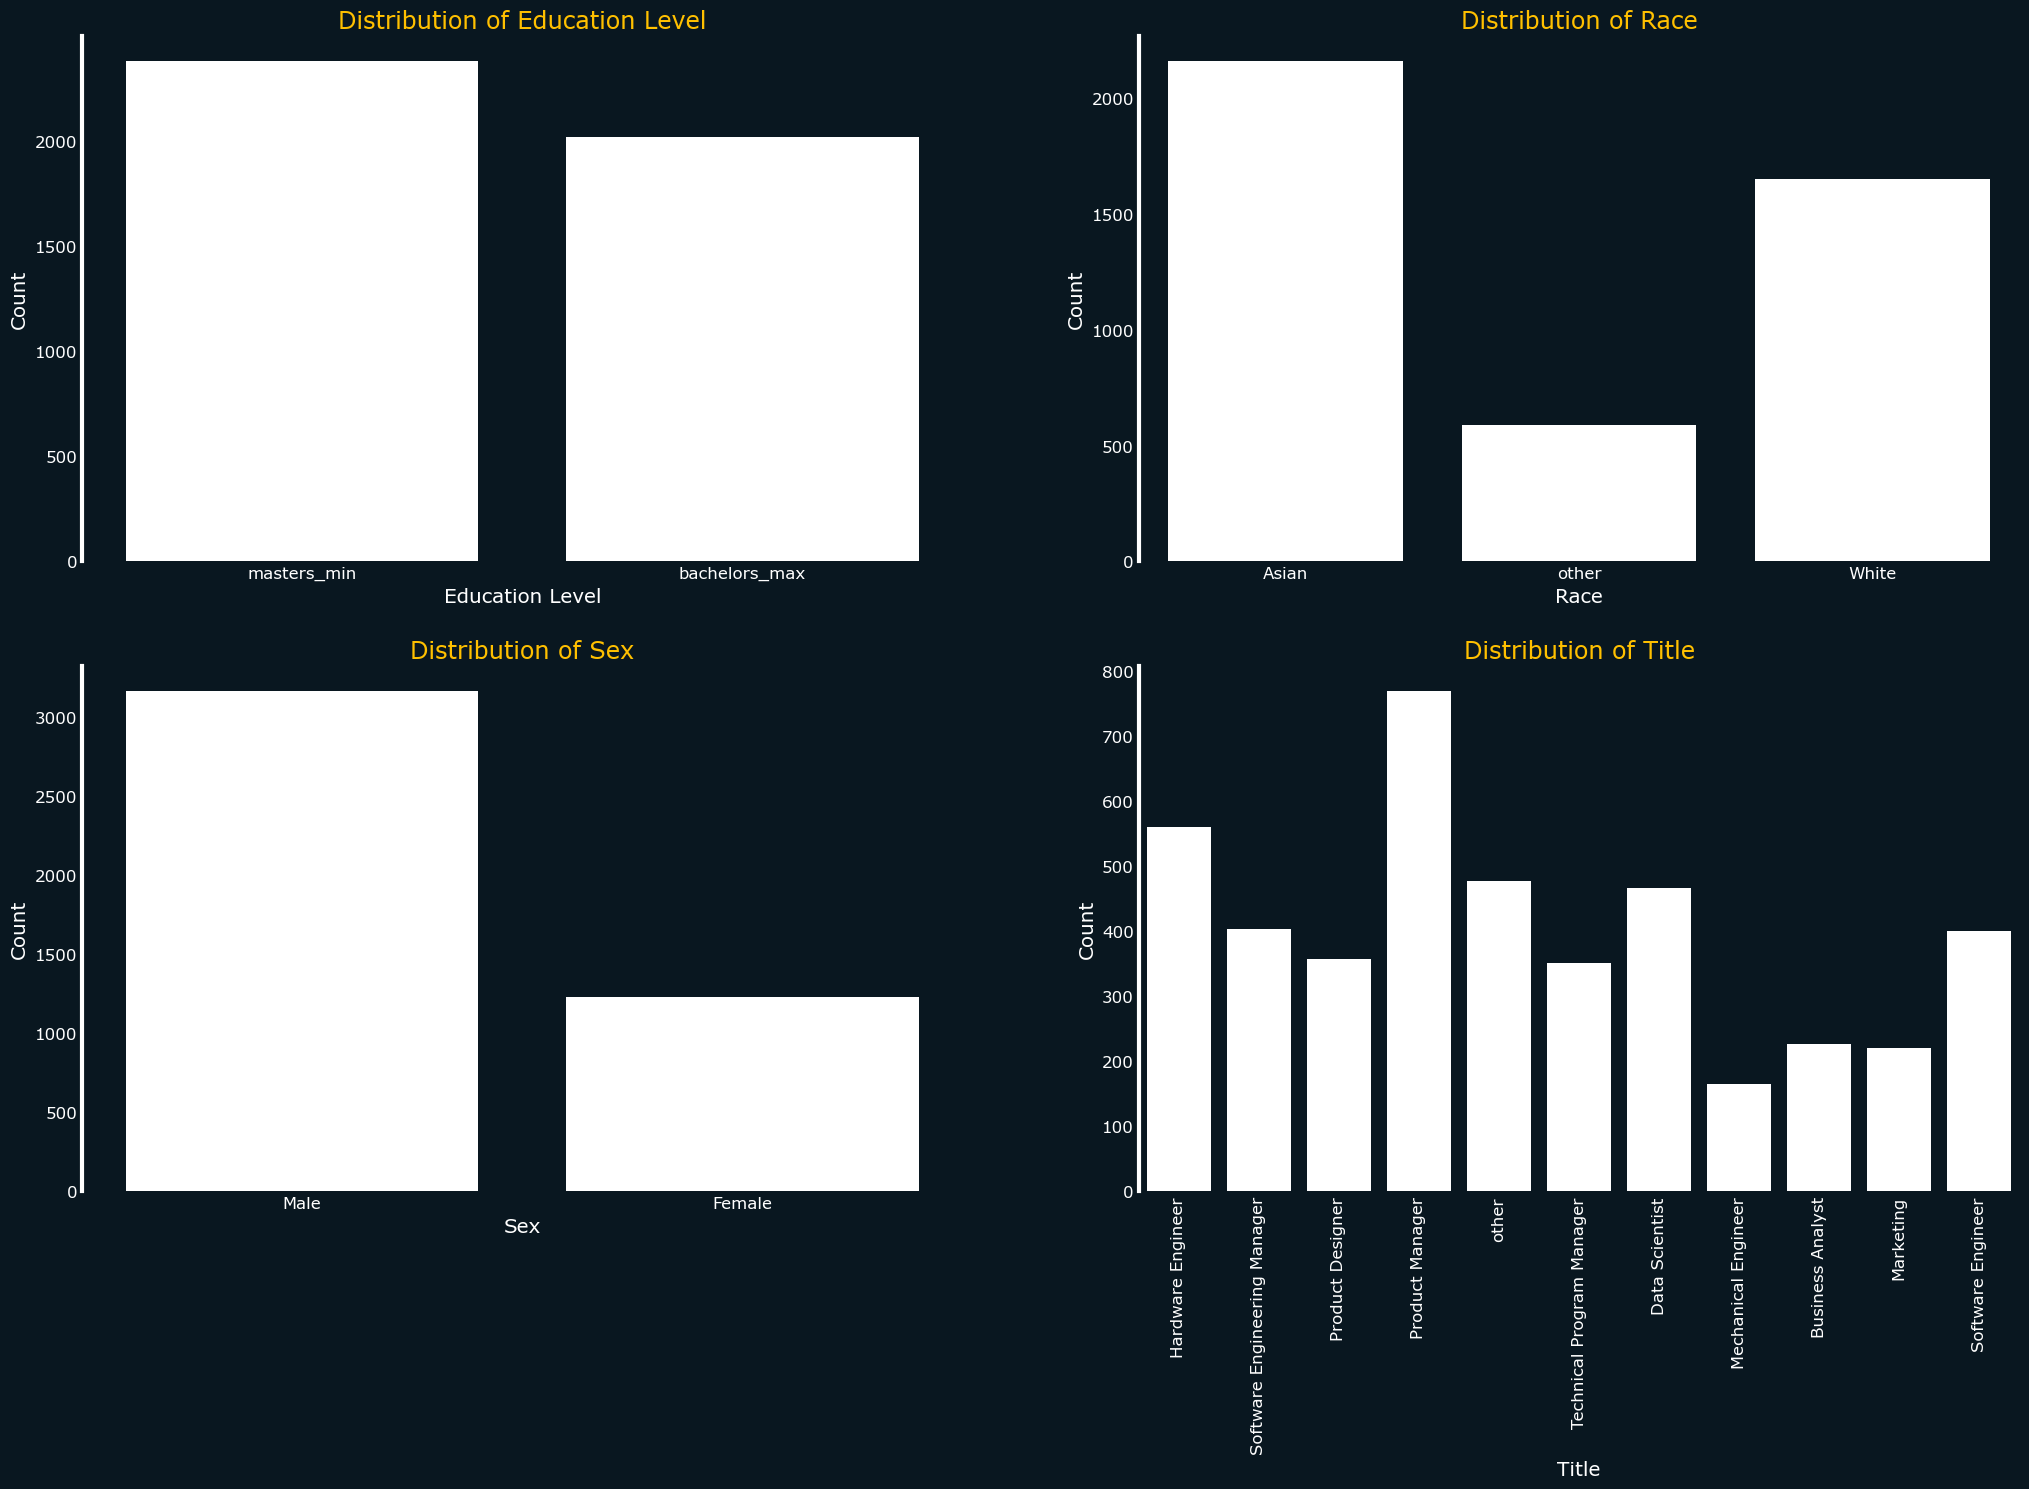

In [396]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='education', data=public_companies, color='white', ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Education Level', color='#FFC000')
ax[0, 0].set_ylabel('Count', color='white')
ax[0, 0].set_xlabel('Education Level', color='white')
ax[0, 0].set_facecolor('#091720')
ax[0, 0].tick_params(axis='y', colors='white')
ax[0, 0].tick_params(axis='x', colors='white')


ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['bottom'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_color('white')

sns.countplot(x='race', data=public_companies, color='white', ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Race', color='#FFC000')
ax[0, 1].set_ylabel('Count', color='white')
ax[0, 1].set_xlabel('Race', color='white')
ax[0, 1].set_facecolor('#091720')
ax[0, 1].tick_params(axis='y', colors='white')
ax[0, 1].tick_params(axis='x', colors='white')


ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['bottom'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_color('white')

sns.countplot(x='sex', data=public_companies, color='white', ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Sex', color='#FFC000')
ax[1, 0].set_ylabel('Count', color='white')
ax[1, 0].set_xlabel('Sex', color='white')
ax[1, 0].set_facecolor('#091720')
ax[1, 0].tick_params(axis='y', colors='white')
ax[1, 0].tick_params(axis='x', colors='white')


ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['left'].set_color('white')

sns.countplot(x='title', data=public_companies, color='white', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Title', color='#FFC000')
ax[1, 1].set_ylabel('Count', color='white')
ax[1, 1].set_xlabel('Title', color='white')
ax[1, 1].set_facecolor('#091720')
ax[1, 1].tick_params(axis='y', colors='white')
ax[1, 1].tick_params(axis='x', colors='white')


ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['left'].set_color('white')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)


plt.show()

# Categorical Data
## Company Level

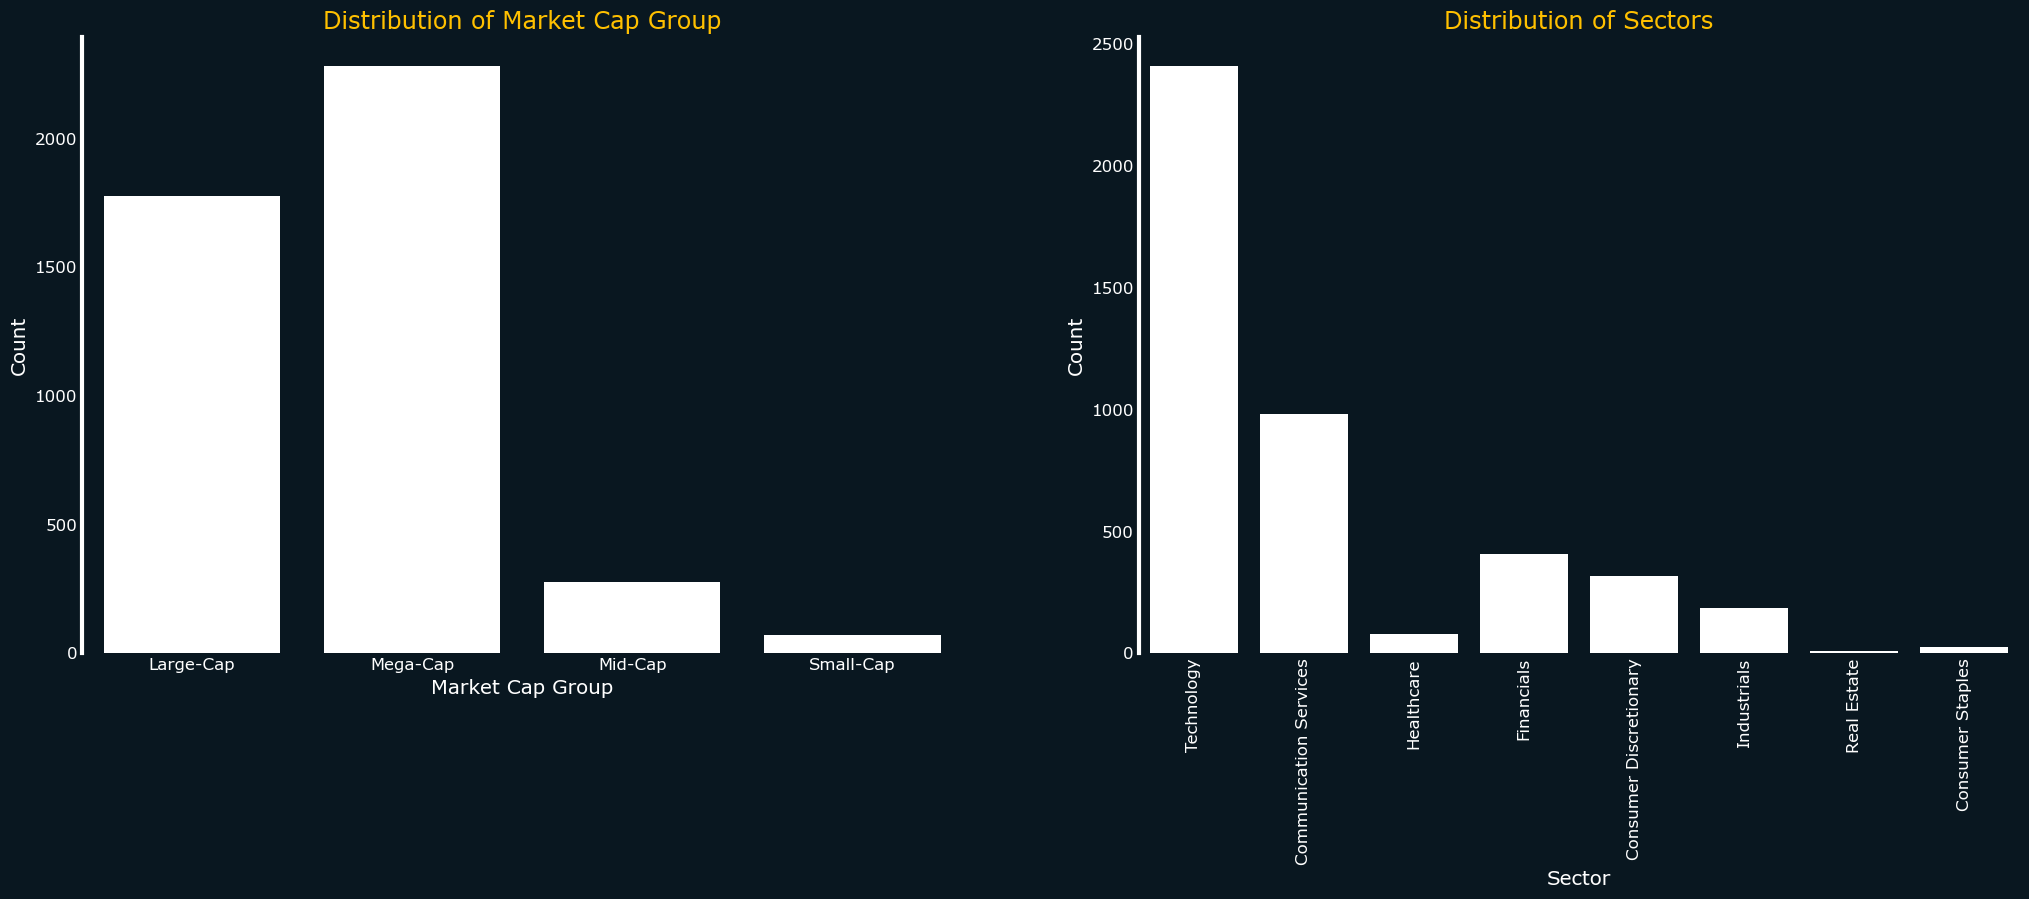

In [397]:
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='mc_group', data=public_companies, color='white', ax=ax[0])
ax[0].set_title('Distribution of Market Cap Group', color='#FFC000')
ax[0].set_ylabel('Count', color='white')
ax[0].set_xlabel('Market Cap Group', color='white')
ax[0].set_facecolor('#091720')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_color('white')
ax[0].set_xticklabels(ax[0].get_xticklabels())

sns.countplot(x='sector', data=public_companies, color='white', ax=ax[1])
ax[1].set_title('Distribution of Sectors', color='#FFC000')
ax[1].set_ylabel('Count', color='white')
ax[1].set_xlabel('Sector', color='white')
ax[1].set_facecolor('#091720')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')


ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_color('white')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


plt.show()

## Reducing Skew

In [398]:
# removing real estate and consumer staples categories from dataset because of low representation
public_companies = public_companies[(public_companies['sector'] != 'Real Estate') & (public_companies['sector'] != 'Consumer Staples')]
public_companies.groupby('sector')['base_salary_std'].count()

sector
Communication Services     982
Consumer Discretionary     314
Financials                 407
Healthcare                  77
Industrials                182
Technology                2408
Name: base_salary_std, dtype: int64

In [399]:
#aggregating values with low representation in the sector category
sector = {"Healthcare": "other",
          "Consumer Discretionary": "other",
          "Financials": "other",
          "Industrials": "other"}

# Replace values
public_companies['sector'] = public_companies['sector'].replace(sector)

In [400]:
# aggregating values with low representation in the market cap group category
mc_group = {"Large-Cap": "large_cap_max",
        "Mid-Cap": "large_cap_max",
        "Small-Cap": "large_cap_max",}

# Replace values
public_companies['mc_group'] = public_companies['mc_group'].replace(mc_group)

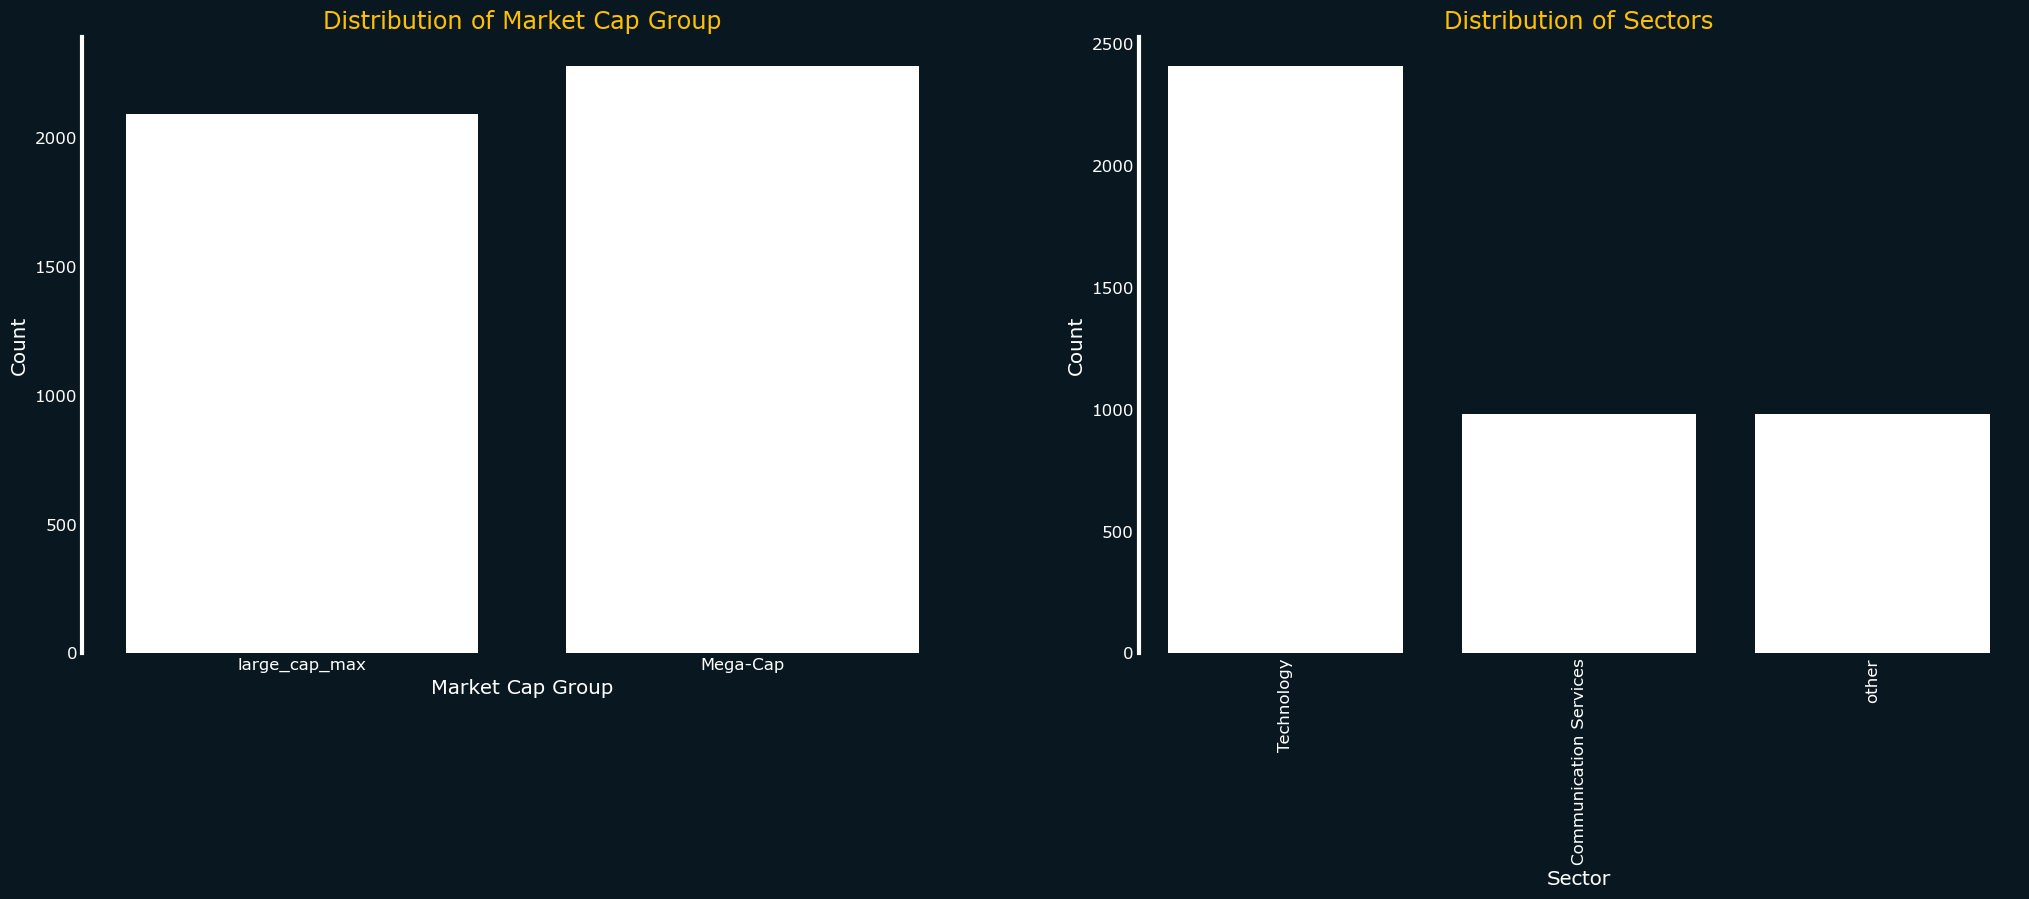

In [401]:
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='mc_group', data=public_companies, color='white', ax=ax[0])
ax[0].set_title('Distribution of Market Cap Group', color='#FFC000')
ax[0].set_ylabel('Count', color='white')
ax[0].set_xlabel('Market Cap Group', color='white')
ax[0].set_facecolor('#091720')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_color('white')
ax[0].set_xticklabels(ax[0].get_xticklabels())

sns.countplot(x='sector', data=public_companies, color='white', ax=ax[1])
ax[1].set_title('Distribution of Sectors', color='#FFC000')
ax[1].set_ylabel('Count', color='white')
ax[1].set_xlabel('Sector', color='white')
ax[1].set_facecolor('#091720')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')


ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_color('white')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


plt.show()

## Sector Balancing

In [402]:
# sampling overrepresented technology value in sector category
sector = public_companies[public_companies['sector'] == 'Technology']
sector = sector.sample(1000, random_state = 42)

# removing technology from sector category in dataset
public_companies = public_companies[public_companies['sector'] != 'Technology']

In [403]:
# adding sampled set of technology sectors to dataset
public_companies = pd.concat([public_companies, sector], ignore_index=True)

## Final Visualizations of Categorical Data

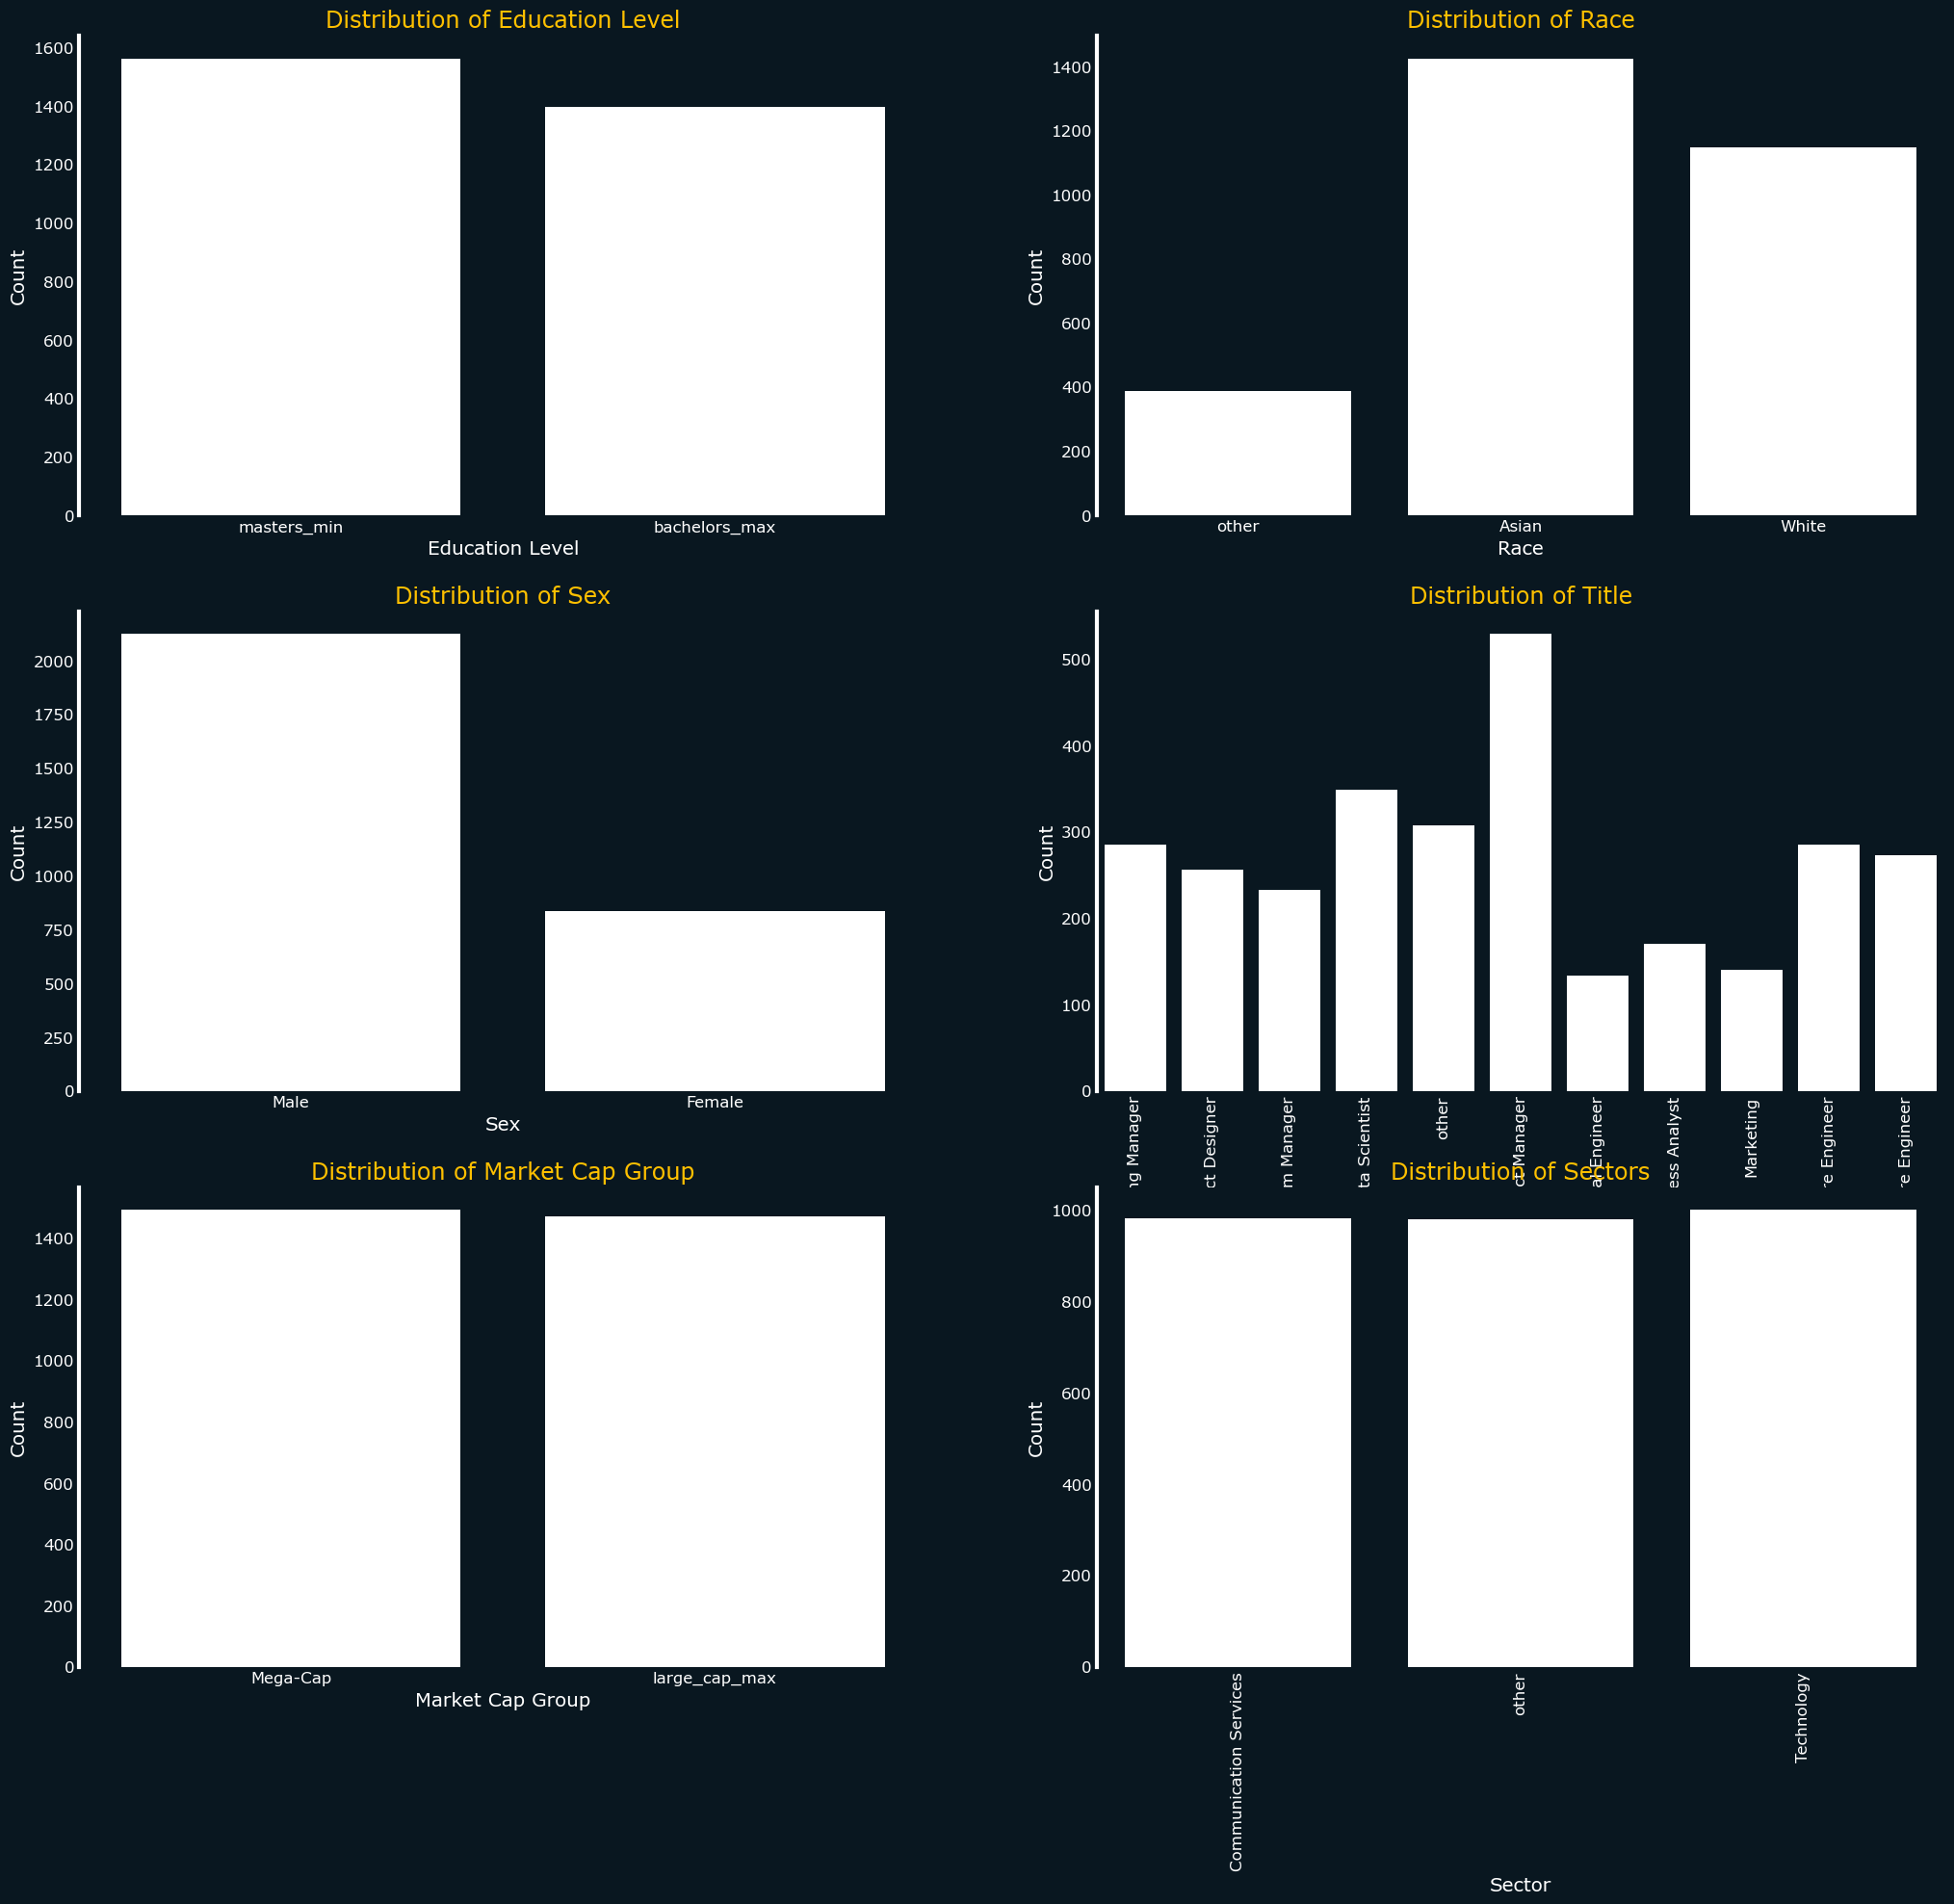

In [404]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(22)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='education', data=public_companies, color='white', ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Education Level', color='#FFC000')
ax[0, 0].set_ylabel('Count', color='white')
ax[0, 0].set_xlabel('Education Level', color='white')
ax[0, 0].set_facecolor('#091720')
ax[0, 0].tick_params(axis='y', colors='white')
ax[0, 0].tick_params(axis='x', colors='white')


ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['bottom'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_color('white')

sns.countplot(x='race', data=public_companies, color='white', ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Race', color='#FFC000')
ax[0, 1].set_ylabel('Count', color='white')
ax[0, 1].set_xlabel('Race', color='white')
ax[0, 1].set_facecolor('#091720')
ax[0, 1].tick_params(axis='y', colors='white')
ax[0, 1].tick_params(axis='x', colors='white')


ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['bottom'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_color('white')

sns.countplot(x='sex', data=public_companies, color='white', ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Sex', color='#FFC000')
ax[1, 0].set_ylabel('Count', color='white')
ax[1, 0].set_xlabel('Sex', color='white')
ax[1, 0].set_facecolor('#091720')
ax[1, 0].tick_params(axis='y', colors='white')
ax[1, 0].tick_params(axis='x', colors='white')


ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['left'].set_color('white')

sns.countplot(x='title', data=public_companies, color='white', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Title', color='#FFC000')
ax[1, 1].set_ylabel('Count', color='white')
ax[1, 1].set_xlabel('Title', color='white')
ax[1, 1].set_facecolor('#091720')
ax[1, 1].tick_params(axis='y', colors='white')
ax[1, 1].tick_params(axis='x', colors='white')


ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['left'].set_color('white')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)

sns.countplot(x='mc_group', data=public_companies, color='white', ax=ax[2, 0])
ax[2, 0].set_title('Distribution of Market Cap Group', color='#FFC000')
ax[2, 0].set_ylabel('Count', color='white')
ax[2, 0].set_xlabel('Market Cap Group', color='white')
ax[2, 0].set_facecolor('#091720')
ax[2, 0].tick_params(axis='y', colors='white')
ax[2, 0].tick_params(axis='x', colors='white')


ax[2, 0].spines['top'].set_visible(False)
ax[2, 0].spines['bottom'].set_visible(False)
ax[2, 0].spines['right'].set_visible(False)
ax[2, 0].spines['left'].set_color('white')
ax[2, 0].set_xticklabels(ax[2, 0].get_xticklabels())

sns.countplot(x='sector', data=public_companies, color='white', ax=ax[2, 1])
ax[2, 1].set_title('Distribution of Sectors', color='#FFC000')
ax[2, 1].set_ylabel('Count', color='white')
ax[2, 1].set_xlabel('Sector', color='white')
ax[2, 1].set_facecolor('#091720')
ax[2, 1].tick_params(axis='y', colors='white')
ax[2, 1].tick_params(axis='x', colors='white')


ax[2, 1].spines['top'].set_visible(False)
ax[2, 1].spines['bottom'].set_visible(False)
ax[2, 1].spines['right'].set_visible(False)
ax[2, 1].spines['left'].set_color('white')
ax[2, 1].set_xticklabels(ax[2, 1].get_xticklabels(), rotation=90)
plt.show()

# Categorical Data Encoding

In [405]:
# encoding nominal categories
x=['title', 'race', 'sex', 'sector']
public_companies = pd.get_dummies(public_companies, columns=['title', 'race', 'sex', 'sector'], prefix=x, drop_first=True, dtype=int)

public_companies.loc[:, 'title_Data Scientist':'sector_Technology'].sample(3)

title_Data Scientist  title_Hardware Engineer  title_Marketing  \
1927                     0                        0                0   
2044                     0                        0                0   
1514                     0                        0                0   

      title_Mechanical Engineer  title_Product Designer  \
1927                          0                       0   
2044                          0                       0   
1514                          0                       0   

      title_Product Manager  title_Software Engineer  \
1927                      0                        1   
2044                      0                        0   
1514                      0                        0   

      title_Software Engineering Manager  title_Technical Program Manager  \
1927                                   0                                0   
2044                                   1                                0   
1514                                   0                                0   

      title_other  race_White  race_other  sex_Male  sector_Technology  
1927            0           0           0         1                  0  
2044            0           0           0         1                  1  
1514            0           0           0         1                  0

In [406]:
# Encoding Ordinal categories
education_dict = {'masters_min': 0, 'bachelors_max': 1}
mc_group_dict = {'large_cap_max': 0, 'Mega-Cap': 1}

# Change values to correspond with dict values
public_companies['education_encoded'] = public_companies['education'].map(education_dict)
public_companies['mc_group_encoded'] = public_companies['mc_group'].map(mc_group_dict)

public_companies[['education', 'education_encoded', 'mc_group', 'mc_group_encoded']].sample(5)

education  education_encoded       mc_group  mc_group_encoded
117   bachelors_max                  1  large_cap_max                 0
546   bachelors_max                  1       Mega-Cap                 1
1304    masters_min                  0       Mega-Cap                 1
749     masters_min                  0       Mega-Cap                 1
142     masters_min                  0       Mega-Cap                 1

# Correlation Analysis

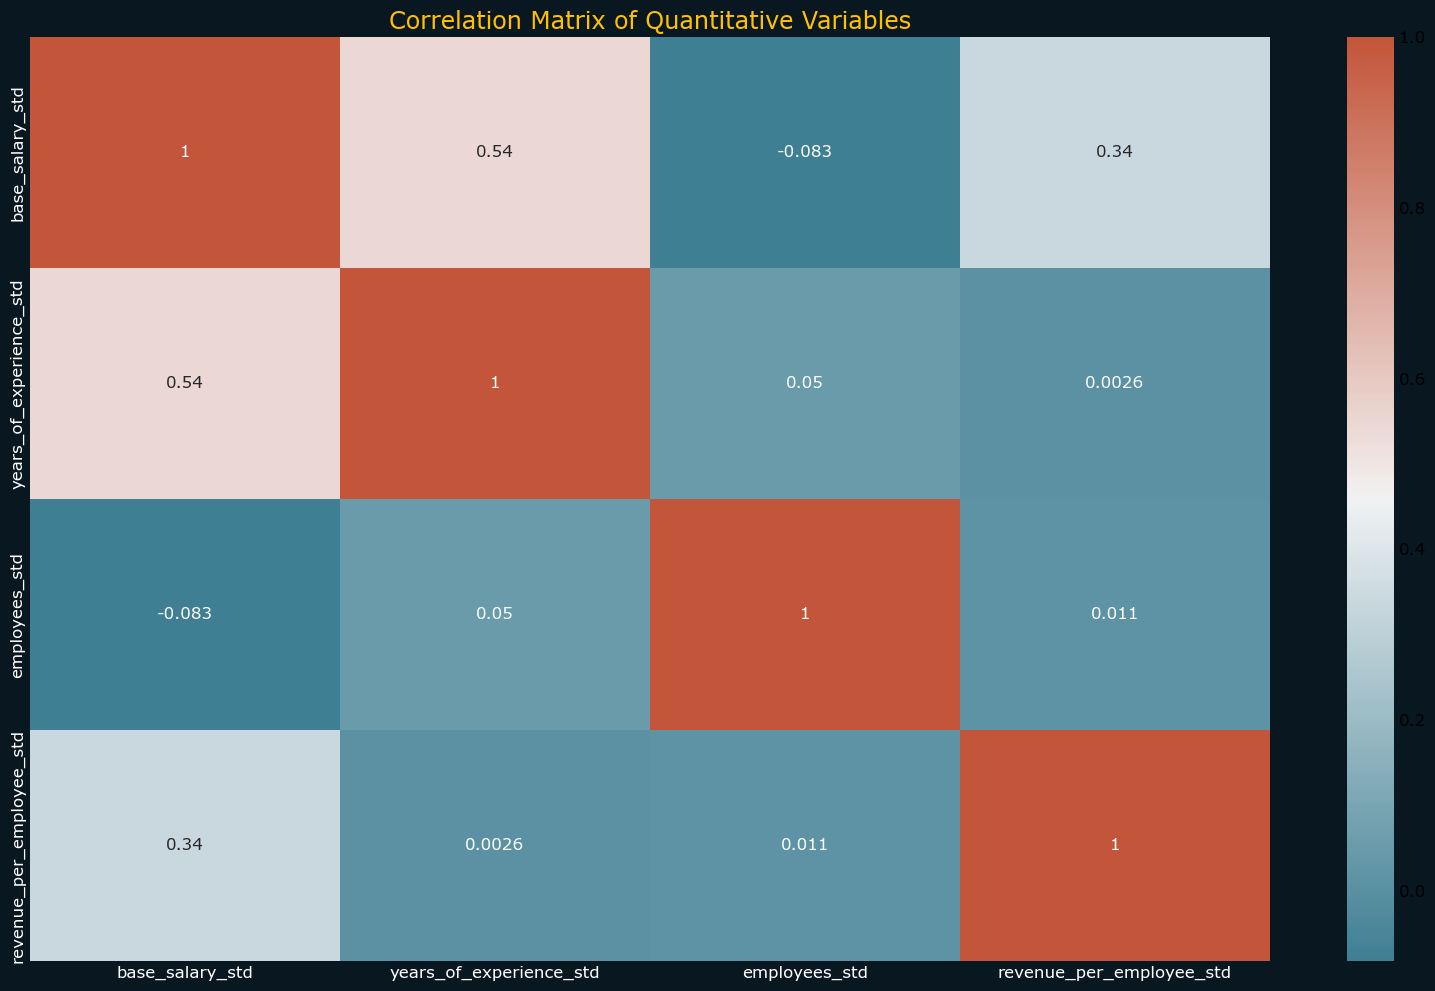

In [407]:
public_companies_cleaned = public_companies[['base_salary_std', 'years_of_experience_std',
                                             'employees_std', 'revenue_per_employee_std']]

corr_matrix = public_companies_cleaned.corr()

# Visualize correlation matrix)
plt.figure(figsize=(20, 12), facecolor='#091720')

sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

plt.tick_params(colors='white')
plt.title('Correlation Matrix of Quantitative Variables', color='#FFC000')
plt.show()

plt.show()

![multiple](multiple.png) 

# Split Dataset

In [408]:
# dropping dependent variable and nonstandardized variables
X = public_companies.drop(['base_salary_std', 'base_salary', 'years_of_experience', 'employees', 'revenue_per_employee', 'education', 'mc_group'], axis=1)

# dependent variable
y = public_companies['base_salary_std']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

## Cross Validation Function

In [409]:
def crossValidationLR(X, y, folds=5, random_state=42, constant=True):
    from statsmodels.stats.stattools import durbin_watson
    from datetime import datetime
    
    # get date and time
    date = datetime.now()
    day = date.strftime("%a, %d %b %Y")
    time = date.strftime('%H:%M:%S')

    # Dictionary to store average statistics
    # list to store params and metrics of each model
    params = []
    r_squared = []
    adj_r_squared =[]
    f_stat = []
    f_p_value = []
    durb_wat = []
    
    # Create list for variable p-values
    if constant:
        p_values = [[] for x in range(X.shape[1] + 1)]
    else:
        p_values = [[] for x in range(X.shape[1])]
    
    # Initialize the cross-validator, set folds to 5
    kf = KFold(n_splits=folds, random_state=random_state, shuffle=True)
    
    # saving column names for reference because they are dropped in conversion
    columns = X.columns
    
    # Convert to numpy array
    X = X.to_numpy()

    # Model each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if constant:
            # Add Constants
            X_train = sm.add_constant(X_train)
            X_test = sm.add_constant(X_test)

        # Train model
        lm = sm.OLS(y_train, X_train).fit()
        
        # Save params and metrics for averaging
        params.append(lm.params)
        r_squared.append(lm.rsquared)
        adj_r_squared.append(lm.rsquared_adj)
        f_stat.append(lm.fvalue)
        f_p_value.append(lm.f_pvalue)
        durb_wat.append(durbin_watson(lm.resid))
            

        for x in range(len(lm.params)):
            p_values[x].append(lm.pvalues[x])
        
        # Save p-values of variables
        for x in range(len(lm.params)): p_values[x].append(lm.pvalues[x])
    
    # Save Statistic Means and stds
    r_squared_mean = np.mean(r_squared)
    r_squared_std = np.std(r_squared)

    adj_r_squared_mean = np.mean(adj_r_squared)
    adj_r_squared_std = np.std(adj_r_squared)

    f_stat_mean = np.mean(f_stat)
    f_stat_std = np.std(f_stat)

    f_p_value_mean = np.mean(f_p_value)
    f_p_value_std = np.std(f_p_value)
    
    p_values_means = [np.mean(values) for values in p_values]
    
    durb_wat_mean = np.mean(durb_wat)
    durb_wat_std = np.std(durb_wat)
    
    # Calculate params from averaging all models params
    params = np.mean(params, axis=0)

    # Print the formatted information with right alignment
    print(f'{"OLS Cross-Validation Averaging":^55}')
    print('=========================================================')
    print(f'{"Num Folds:"} {folds:>46}')
    print(f'{"Dep. Variable:"} {y.name:>42}')
    print(f'{"Model:"} {"OLS":>50}')
    print(f'{"Method:"} {"Least Squares":>49}')
    print(f'{"Date:"} {day:>51}')
    print(f'{"Time:"} {time:>51}')
    print('=========================================================')
    
    # Print Statistic Means
    print(f'{"mean":>46}  {"std.":>9}')
    print('---------------------------------------------------------')
    print(f'{"R-squared":>35} {r_squared_mean:>10.3f} {r_squared_std:>10.3f}')
    print(f'{"Adj. R-squared":>35} {adj_r_squared_mean:>10.3f} {adj_r_squared_std:>10.3f}')
    print(f'{"F-statistic":>35} {f_stat_mean:>10.3f} {f_stat_std:>10.3f}')
    print(f'{"Prob (F-statistic)":>35} {f_p_value_mean:>10.3f} {f_p_value_std:>10.3f}')
    print(f"{'Durbin-Watson':>35} {durb_wat_mean:>10.3f} {durb_wat_std:>10.3f}")

    if constant:
    # Print Coefficients and P-values with constant
        print('=========================================================')
        print(f'{"coef":>46}  {"P>|t|":>9}')
        print('---------------------------------------------------------')
        print(f'{"const":>35} {params[0]:>10,.3f} {p_values_means[0]:>10,.3f}')
        for x in range(0, len(columns)):
            print(f'{columns[x]:>35} {params[x+1]:>10.3f} {p_values_means[x]:>10.3f}')
        print('\n=========================================================\n')
    
    else:
         # Print Coefficients and P-values without constant
        print('=========================================================')
        print(f'{"coef":>46}  {"P>|t|":>9}')
        print('---------------------------------------------------------')
        for x in range(0, len(columns)):
            print(f'{columns[x]:>35} {params[x]:>10.3f} {p_values_means[x]:>10.3f}')
        print('\n=========================================================\n')
    ''' Create Model using cross validation params'''

    # Train/Test Split of all data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    # Add constant
    if constant:
        X_train = sm.add_constant(X_train)
    # Initialize new model 
    lm = sm.OLS(y_train, X_train).fit()
    
    # Update the model parameters with the average coefficients
    lm.params = params
    # Update lm attributes to be able to acces durbin watson without returning it
    lm.durb_wat_mean = durb_wat_mean
    
    return lm

# Multivariate Linear Regression Modeling

## Analyze Removal of Quantitative Variables

Our goal is to evaluate quantitative variables based on p-value.  Those with a p-value over .05 will be eliminated from the model.  This will be done one by one with the maximum p-value being removed on each iteration.

In [410]:
lm  = crossValidationLR(X, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:20
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.557      0.012
                     Adj. R-squared      0.553      0.012
                        F-statistic    147.614      6.808
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.966      0.012
                                          coef      P>|t|
---------------------------------------------------------
                              const     -0.837      0.000
            year

In [411]:
y_pred = lm.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.33428024475235
Linear Regression - MAE: 0.45030645089790017


# Analyze Removal of Categorical Variables

Here we will be test building a model without each of the categorical variables with replacement.  We expect the overall fit of the model to decrease with each variable removed, however those with little impact on the overall fit will be removed from the variables of interest to maximize the effect of the most significant variables.

## Test Removing Education

In [412]:
X_revised        =       X.drop(columns='education_encoded', inplace=False)
X_train_revised  = X_train.drop(columns='education_encoded', inplace=False)
X_test_revised   =  X_test.drop(columns='education_encoded', inplace=False)

lm  = crossValidationLR(X_revised, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:20
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.546      0.012
                     Adj. R-squared      0.543      0.012
                        F-statistic    149.068      7.215
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.965      0.011
                                          coef      P>|t|
---------------------------------------------------------
                              const     -0.920      0.000
            year

In [413]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.34181137958146063
Linear Regression - MAE: 0.45801523984640524


# Test Removing Sex

In [414]:
X_revised        =       X.drop(columns='sex_Male', inplace=False)
X_train_revised  = X_train.drop(columns='sex_Male', inplace=False)
X_test_revised   =  X_test.drop(columns='sex_Male', inplace=False)

lm  = crossValidationLR(X_revised, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:20
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.555      0.011
                     Adj. R-squared      0.551      0.012
                        F-statistic    154.206      7.052
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.962      0.012
                                          coef      P>|t|
---------------------------------------------------------
                              const     -0.775      0.000
            year

### Result
>Removing sex decreased r^2 and adjusted r^2 by .001.  We can conlude based on this that sex is not a significant variable to the model.

In [415]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.33339754268141863
Linear Regression - MAE: 0.449607665221061


# Test Removing Race

In [416]:
X_revised        =       X.drop(columns=['race_White', 'race_other'], inplace=False)
X_train_revised  = X_train.drop(columns=['race_White', 'race_other'], inplace=False)
X_test_revised   =  X_test.drop(columns=['race_White', 'race_other'], inplace=False)

lm  = crossValidationLR(X_revised, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:21
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.556      0.012
                     Adj. R-squared      0.552      0.012
                        F-statistic    163.428      7.638
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.968      0.011
                                          coef      P>|t|
---------------------------------------------------------
                              const     -0.828      0.000
            year

In [417]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.33472913161725815
Linear Regression - MAE: 0.45041705627960626


# Test Removing Sector

In [418]:
X_revised        =       X.drop(columns=['sector_Technology', 'sector_other'], inplace=False)
X_train_revised  = X_train.drop(columns=['sector_Technology', 'sector_other'], inplace=False)
X_test_revised   =  X_test.drop(columns=['sector_Technology', 'sector_other'], inplace=False)

lm  = crossValidationLR(X_revised, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:21
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.540      0.012
                     Adj. R-squared      0.537      0.012
                        F-statistic    153.587      7.211
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.971      0.014
                                          coef      P>|t|
---------------------------------------------------------
                              const     -1.078      0.000
            year

In [419]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3520557144059954
Linear Regression - MAE: 0.4644404428477072


# Test Removing Market Cap Group

In [420]:
X_revised        =       X.drop(columns=['mc_group_encoded'], inplace=False)
X_train_revised  = X_train.drop(columns=['mc_group_encoded'], inplace=False)
X_test_revised   =  X_test.drop(columns=['mc_group_encoded'], inplace=False)

lm  = crossValidationLR(X_revised, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:21
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.553      0.012
                     Adj. R-squared      0.549      0.012
                        F-statistic    152.904      7.133
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.963      0.011
                                          coef      P>|t|
---------------------------------------------------------
                              const     -0.656      0.000
            year

In [421]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3384031272912048
Linear Regression - MAE: 0.4538401320700534


# Test Removing Title

In [422]:
X_revised        =       X.drop(columns=['title_Data Scientist',
                                         'title_Hardware Engineer',
                                         'title_Marketing',
                                         'title_Mechanical Engineer',	
                                         'title_Product Designer',	
                                         'title_Product Manager',	
                                         'title_Software Engineer',	
                                         'title_Software Engineering Manager',	
                                         'title_Technical Program Manager',
                                         'title_other'], inplace=False)
X_train_revised  = X_train.drop(columns=['title_Data Scientist',
                                         'title_Hardware Engineer',
                                         'title_Marketing',
                                         'title_Mechanical Engineer',	
                                         'title_Product Designer',	
                                         'title_Product Manager',	
                                         'title_Software Engineer',	
                                         'title_Software Engineering Manager',	
                                         'title_Technical Program Manager',
                                         'title_other'], inplace=False)
X_test_revised   =  X_test.drop(columns=['title_Data Scientist',
                                         'title_Hardware Engineer',
                                         'title_Marketing',
                                         'title_Mechanical Engineer',	
                                         'title_Product Designer',	
                                         'title_Product Manager',	
                                         'title_Software Engineer',	
                                         'title_Software Engineering Manager',	
                                         'title_Technical Program Manager',
                                         'title_other'], inplace=False)

lm  = crossValidationLR(X_revised, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:21
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.473      0.011
                     Adj. R-squared      0.471      0.011
                        F-statistic    212.085      8.855
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.938      0.008
                                          coef      P>|t|
---------------------------------------------------------
                              const     -0.410      0.000
            year

In [423]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.39283557088881715
Linear Regression - MAE: 0.5031574269993339


# Model with Original Dataset Variables Exclusively

> Here we want to analyze the difference between models calculated with the stock dataset and without to compare overall fit.

In [424]:
X_revised        =       X.drop( columns=['employees_std',
                                          'revenue_per_employee_std', 
                                          'mc_group_encoded',
                                          'sector_other',
                                          'sector_Technology'], inplace=False)
X_train_revised  = X_train.drop( columns=['employees_std',
                                          'revenue_per_employee_std', 
                                          'mc_group_encoded',
                                          'sector_other',
                                          'sector_Technology'], inplace=False)
X_test_revised   =  X_test.drop( columns=['employees_std',
                                          'revenue_per_employee_std', 
                                          'mc_group_encoded',
                                          'sector_other',
                                          'sector_Technology'], inplace=False)

lm1  = crossValidationLR(X_revised, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:21
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.411      0.014
                     Adj. R-squared      0.407      0.014
                        F-statistic    109.477      6.201
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.963      0.016
                                          coef      P>|t|
---------------------------------------------------------
                              const     -0.630      0.000
            year

In [425]:
y_pred2 = lm1.predict(X_test_revised)
print("Linear Regression - MSE:",  mean_squared_error(y_test, y_pred2))
print("Linear Regression - MAE:", mean_absolute_error(y_test, y_pred2))

Linear Regression - MSE: 0.4334024093405255
Linear Regression - MAE: 0.5251991746769873


# Test Removing Combinations of Categorical Variables

In [426]:
X              =       X.drop(columns=['sex_Male', 
                                       'mc_group_encoded',
                                       'race_White',
                                       'race_other',
                                       'sector_Technology', 
                                       'sector_other'], inplace=False)
X_train_final  = X_train.drop(columns=['sex_Male', 
                                       'mc_group_encoded',
                                       'race_White',
                                       'race_other',
                                       'sector_Technology', 
                                       'sector_other'], inplace=False)
X_test_final   =  X_test.drop(columns=['sex_Male', 
                                       'mc_group_encoded',
                                       'race_White',
                                       'race_other',
                                       'sector_Technology', 
                                       'sector_other'], inplace=False)

lm  = crossValidationLR(X, y)

            OLS Cross-Validation Averaging             
Num Folds:                                              5
Dep. Variable:                            base_salary_std
Model:                                                OLS
Method:                                     Least Squares
Date:                                    Wed, 17 Apr 2024
Time:                                            09:11:22
                                          mean       std.
---------------------------------------------------------
                          R-squared      0.528      0.012
                     Adj. R-squared      0.525      0.012
                        F-statistic    188.165      8.953
                 Prob (F-statistic)      0.000      0.000
                      Durbin-Watson      1.963      0.013
                                          coef      P>|t|
---------------------------------------------------------
                              const     -0.766      0.000
            year

In [427]:
y_pred = lm.predict(X_test_final)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
lr_r2 = lm.rsquared
lr_ar2 = lm.rsquared_adj

print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.35975066497652564
Linear Regression - MAE: 0.4706372174773498


# Expanding the Dataset to Evaluate Models

Here we are using the public companies copy made earlier.  We are repeating some of the transformations made to the public companies dataset in order to correspond with the model, however we will not be removing entries with disproportionate amounts of data.  This was originally done by removing a category, sampling that category, and replacing the sample.

In [428]:
#remove outliers
public_companies_copy = removeOutliersIQR(public_companies_copy, 'base_salary_std')
public_companies_copy = removeOutliersIQR(public_companies_copy, 'years_of_experience_std')
public_companies_copy = removeOutliersIQR(public_companies_copy, 'employees_std')
public_companies_copy = removeOutliersIQR(public_companies_copy, 'revenue_per_employee_std')

#drop categorical values with low representation
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['mc_group'] == 'Micro-Cap'].index)
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['mc_group'] == 'Nano-Cap'].index)
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['sector'] == 'Energy'].index)
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['sector'] == 'Materials'].index)
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['sector'] == 'Utilities'].index)
public_companies_copy = public_companies_copy[public_companies_copy['sex'] != 'Other']
public_companies_copy = public_companies_copy[(public_companies_copy['sector'] != 'Real Estate') & (public_companies_copy['sector'] != 'Consumer Staples')]

# Aggregating education levels into 2 categories
education = {
    "Highschool": "bachelors_max",
    "Some College": "bachelors_max",
    "Bachelor's Degree": "bachelors_max",
    "Master's Degree": "masters_min",
    "PhD": "masters_min"}

# Replace values
public_companies_copy['education'] = public_companies_copy['education'].replace(education)

# Aggregating race categories with low representation
race = {"Black": "other",
        "Hispanic": "other",
        "Two Or More": "other"}

# Replace values
public_companies_copy['race'] = public_companies_copy['race'].replace(race)

# aggregating title values with low representation
title = {"Management Consultant": "other",
          "Recruiter": "other",
          "Human Resources": "other",
          'Sales': 'other',
          'Solution Architect': 'other'}

# Replace values
public_companies_copy['title'] = public_companies_copy['title'].replace(title)

#aggregating values with low representation in the sector category
sector = {"Healthcare": "other",
          "Consumer Discretionary": "other",
          "Financials": "other",
          "Industrials": "other"}

# Replace values
public_companies_copy['sector'] = public_companies_copy['sector'].replace(sector)

# aggregating values with low representation in the market cap group category
mc_group = {"Large-Cap": "large_cap_max",
        "Mid-Cap": "large_cap_max",
        "Small-Cap": "large_cap_max",}

# Replace values
public_companies_copy['mc_group'] = public_companies_copy['mc_group'].replace(mc_group)

# encoding nominal categories
public_companies_copy_copy = public_companies_copy
x=['title', 'race', 'sex', 'sector']
public_companies_copy = pd.get_dummies(public_companies_copy, columns=['title', 'race', 'sex', 'sector'], prefix=x, drop_first=True, dtype=int)

# Encoding Ordinal categories
education_dict = {'masters_min': 0, 'bachelors_max': 1}
mc_group_dict = {'large_cap_max': 0, 'Mega-Cap': 1}

# Change values to correspond with dict values
public_companies_copy['education_encoded'] = public_companies_copy['education'].map(education_dict)
public_companies_copy['mc_group_encoded'] = public_companies_copy['mc_group'].map(mc_group_dict)



# dropping dependent variable, nonstandardized variables, and variables not in final model
X_full = public_companies_copy.drop(['base_salary_std', 
                                     'base_salary', 
                                     'years_of_experience', 
                                     'employees', 
                                     'revenue_per_employee', 
                                     'education', 
                                     'mc_group',
                                     'sex_Male', 
                                     'mc_group_encoded',
                                     'race_White',
                                     'race_other',
                                     'sector_Technology', 
                                     'sector_other'], axis=1)
# add constant column to test
X_full.insert(0, 'const', 1)

# dependent variable
y_full = public_companies_copy['base_salary_std']

In [429]:
X_full.shape

(10739, 15)

In [430]:
X.shape

(2962, 14)

You can see the expansion of the dataset by the shapes of X_full and X_shape. We can use the expanded dataset to test the model.

# Testing Assumptions

# Linearity

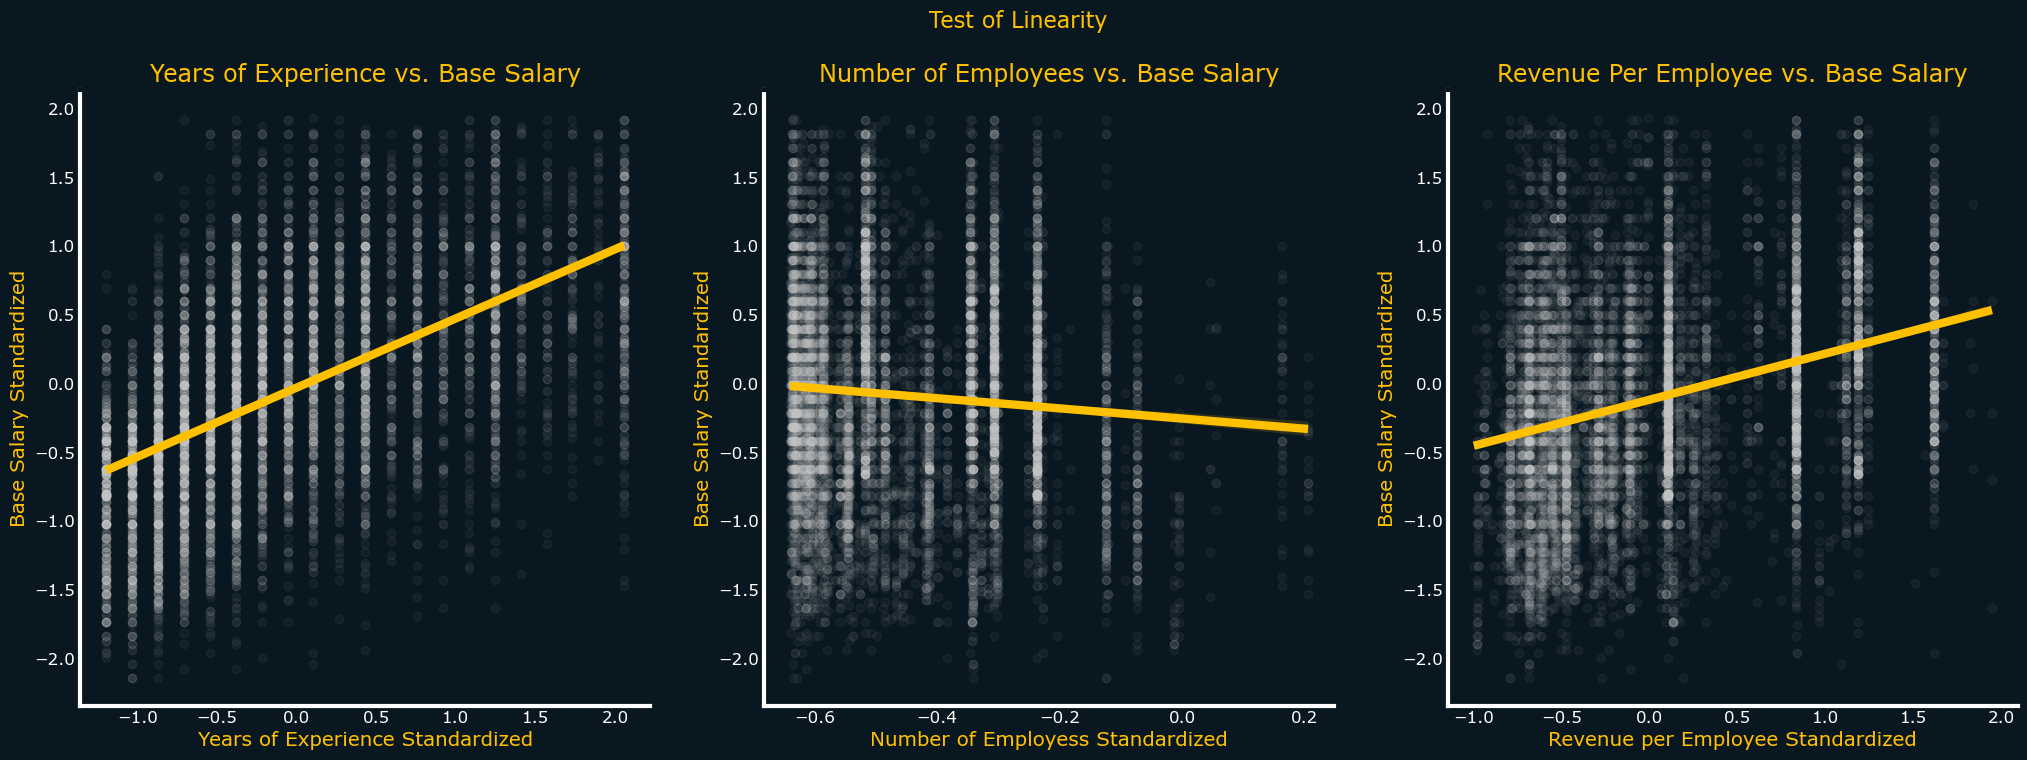

In [431]:
fig, ax = plt.subplots(ncols=3)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Test of Linearity', color='#FFC000', fontsize=16)

# Years of Experience
sns.regplot(x=X_full['years_of_experience_std'], y=y_full, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[0])
ax[0].set_title('Years of Experience vs. Base Salary', color='#FFC000')
ax[0].set_xlabel('Years of Experience Standardized', color='#FFC000')
ax[0].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

# Number of Employees
sns.regplot(x=X_full['employees_std'], y=y_full, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[1])
ax[1].set_title('Number of Employees vs. Base Salary', color='#FFC000')
ax[1].set_xlabel('Number of Employess Standardized', color='#FFC000')
ax[1].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

# Revenue per Employee
sns.regplot(x=X_full['revenue_per_employee_std'], y=y_full, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[2])
ax[2].set_title('Revenue Per Employee vs. Base Salary', color='#FFC000')
ax[2].set_xlabel('Revenue per Employee Standardized', color='#FFC000')
ax[2].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[2].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='x', colors='white')

ax[2].spines['bottom'].set_color('white')
ax[2].spines['top'].set_color('#091720') 
ax[2].spines['right'].set_color('#091720')
ax[2].spines['left'].set_color('white')
ax[2].set_facecolor('#091720')
plt.show()

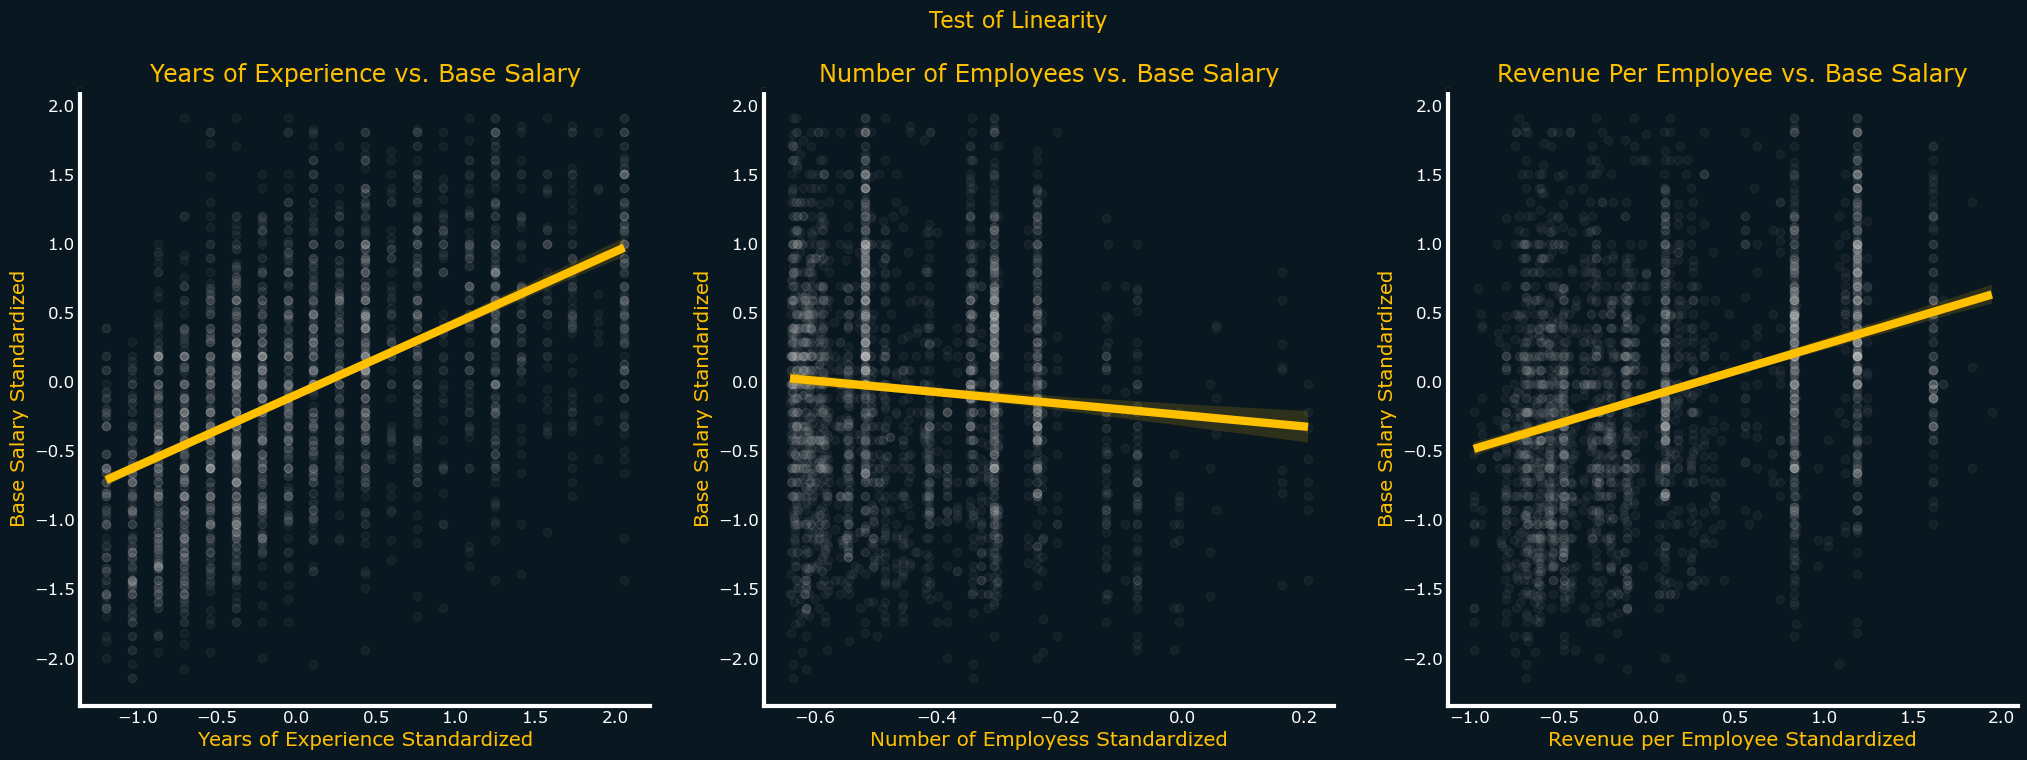

In [432]:
fig, ax = plt.subplots(ncols=3)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Test of Linearity', color='#FFC000', fontsize=16)

# Years of Experience
sns.regplot(x=X['years_of_experience_std'], y=y, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[0])
ax[0].set_title('Years of Experience vs. Base Salary', color='#FFC000')
ax[0].set_xlabel('Years of Experience Standardized', color='#FFC000')
ax[0].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

# Number of Employees
sns.regplot(x=X['employees_std'], y=y, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[1])
ax[1].set_title('Number of Employees vs. Base Salary', color='#FFC000')
ax[1].set_xlabel('Number of Employess Standardized', color='#FFC000')
ax[1].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

# Revenue per Employee
sns.regplot(x=X['revenue_per_employee_std'], y=y, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[2])
ax[2].set_title('Revenue Per Employee vs. Base Salary', color='#FFC000')
ax[2].set_xlabel('Revenue per Employee Standardized', color='#FFC000')
ax[2].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[2].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='x', colors='white')

ax[2].spines['bottom'].set_color('white')
ax[2].spines['top'].set_color('#091720') 
ax[2].spines['right'].set_color('#091720')
ax[2].spines['left'].set_color('white')
ax[2].set_facecolor('#091720')
plt.show()


# Collinearity

In [433]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF scores for all the predictors
VIFs = [variance_inflation_factor(X_full.values, i) for i in range(X_full.shape[1])]
for i, vif in enumerate(VIFs):
    print(f"VIF for {X_full.columns[i]}: {vif}")

VIF for const: 56.98481648853986
VIF for years_of_experience_std: 1.1770539365233659
VIF for employees_std: 1.0102535670803225
VIF for revenue_per_employee_std: 1.0160578783635932
VIF for title_Data Scientist: 2.9904957618111294
VIF for title_Hardware Engineer: 3.3925387831671845
VIF for title_Marketing: 1.9638357299438645
VIF for title_Mechanical Engineer: 1.726652177665246
VIF for title_Product Designer: 2.5141223120526055
VIF for title_Product Manager: 4.147980038013698
VIF for title_Software Engineer: 11.712606787772206
VIF for title_Software Engineering Manager: 2.7949039562115674
VIF for title_Technical Program Manager: 2.555372491764909
VIF for title_other: 3.0430402596135018
VIF for education_encoded: 1.05858806186105


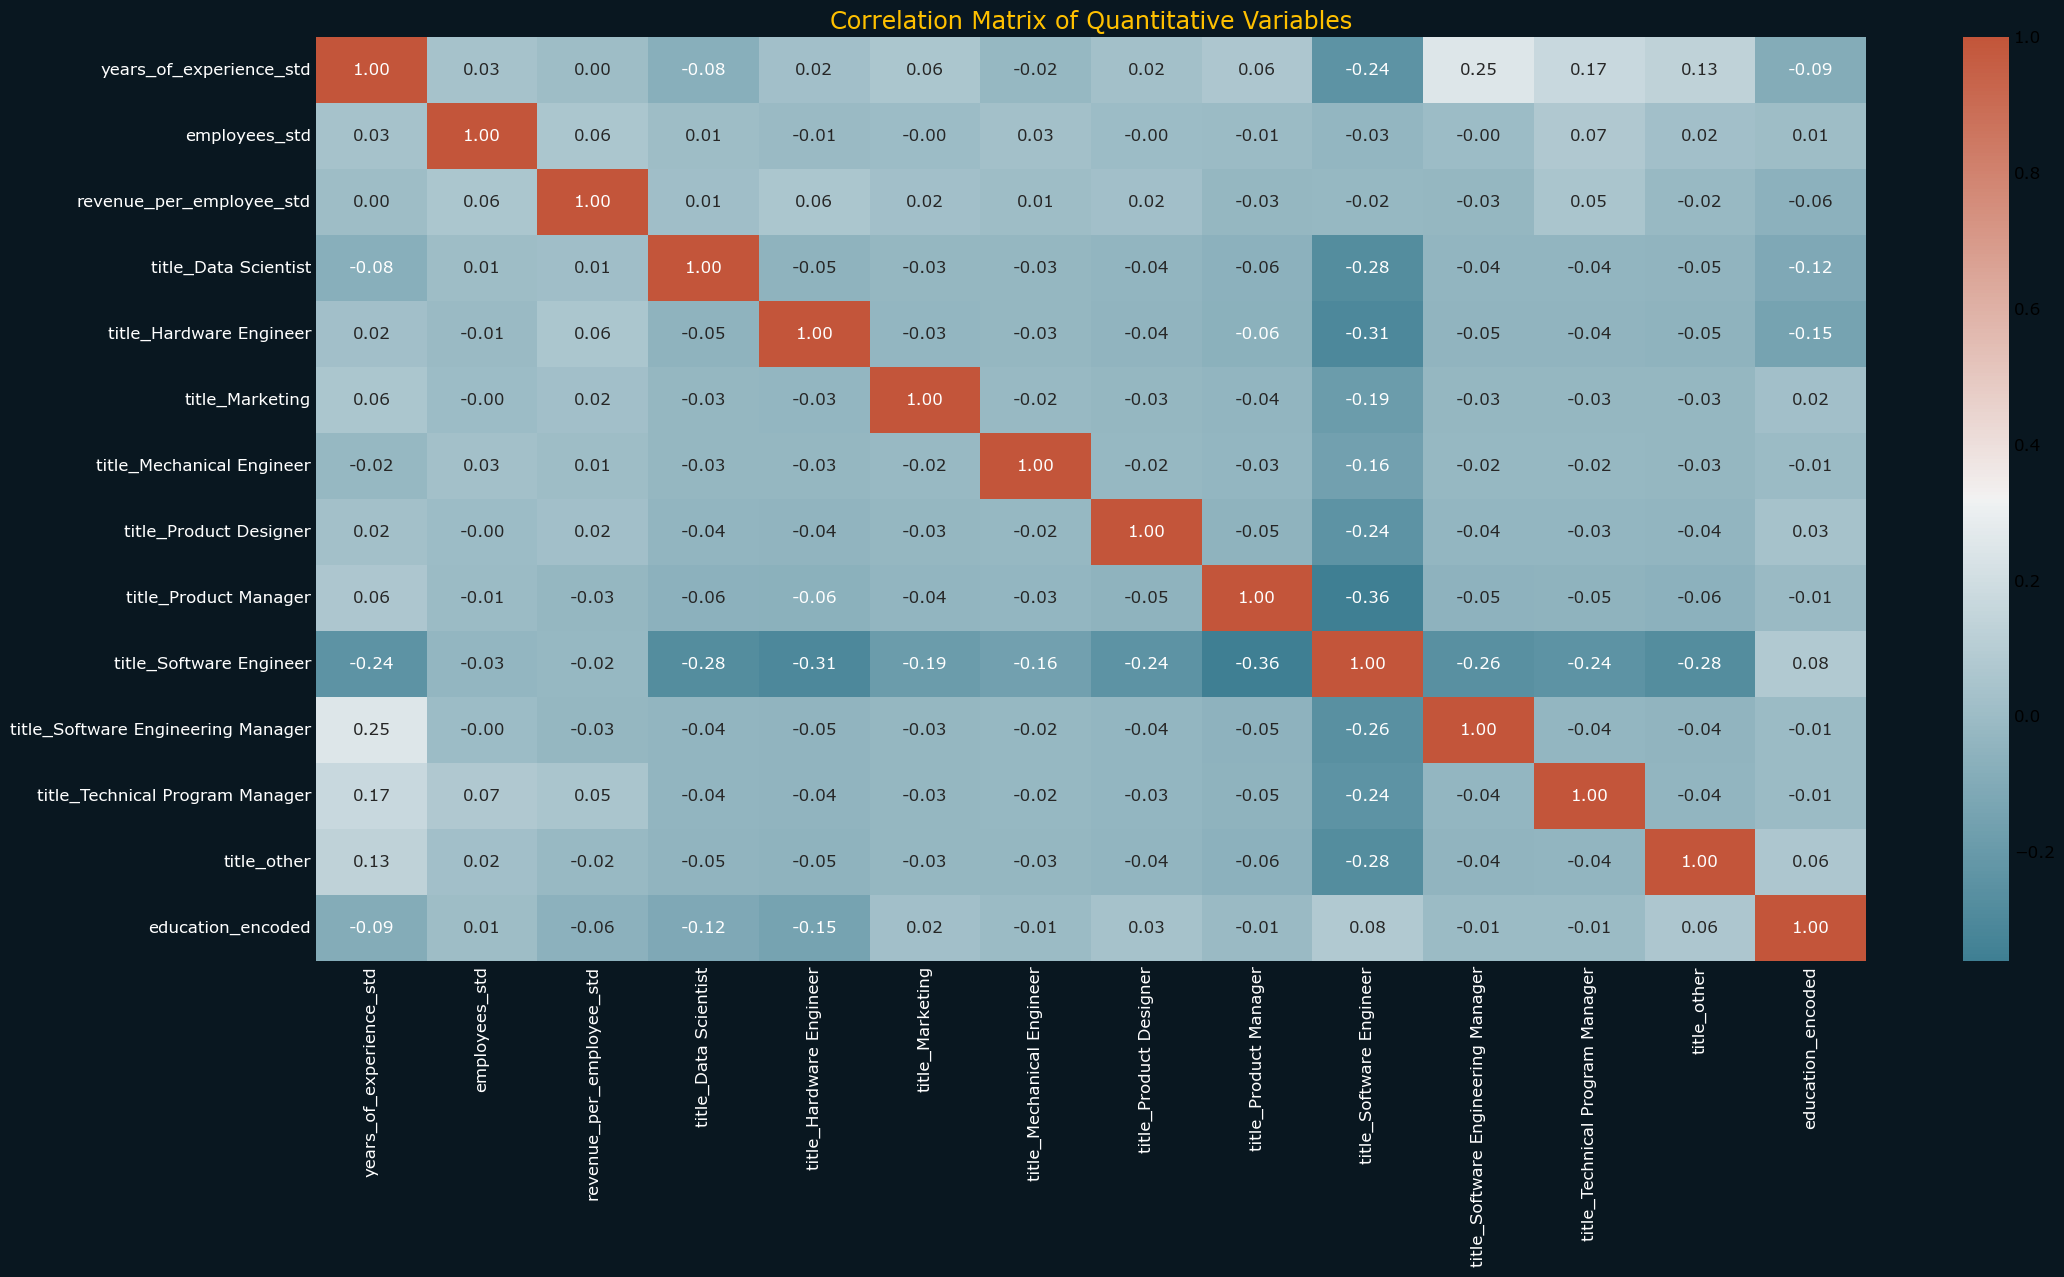

In [434]:
# Compute the correlation matrix
X_full_no_const = X_full.drop(columns='const', axis=1)
corr_matrix = X_full_no_const.corr()

# Visualize correlation matrix)
plt.figure(figsize=(25, 12), facecolor='#091720')

sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), fmt=".2f")

plt.tick_params(colors='white')
plt.title('Correlation Matrix of Quantitative Variables', color='#FFC000')
plt.show()

plt.show()

In [435]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF scores for all the predictors
VIFs = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
for i, vif in enumerate(VIFs):
    print(f"VIF for {X.columns[i]}: {vif}")

VIF for years_of_experience_std: 1.295818859220537
VIF for employees_std: 6.22847369618048
VIF for revenue_per_employee_std: 1.0738810828414487
VIF for title_Data Scientist: 1.6974464189127823
VIF for title_Hardware Engineer: 1.5373179146563019
VIF for title_Marketing: 1.3192205542643884
VIF for title_Mechanical Engineer: 1.2178144305883558
VIF for title_Product Designer: 1.5799656996981206
VIF for title_Product Manager: 2.1016523112054077
VIF for title_Software Engineer: 1.5601391967497085
VIF for title_Software Engineering Manager: 1.8039174087633794
VIF for title_Technical Program Manager: 1.4543715563199264
VIF for title_other: 1.7013329171018496
VIF for education_encoded: 1.9923567032815588


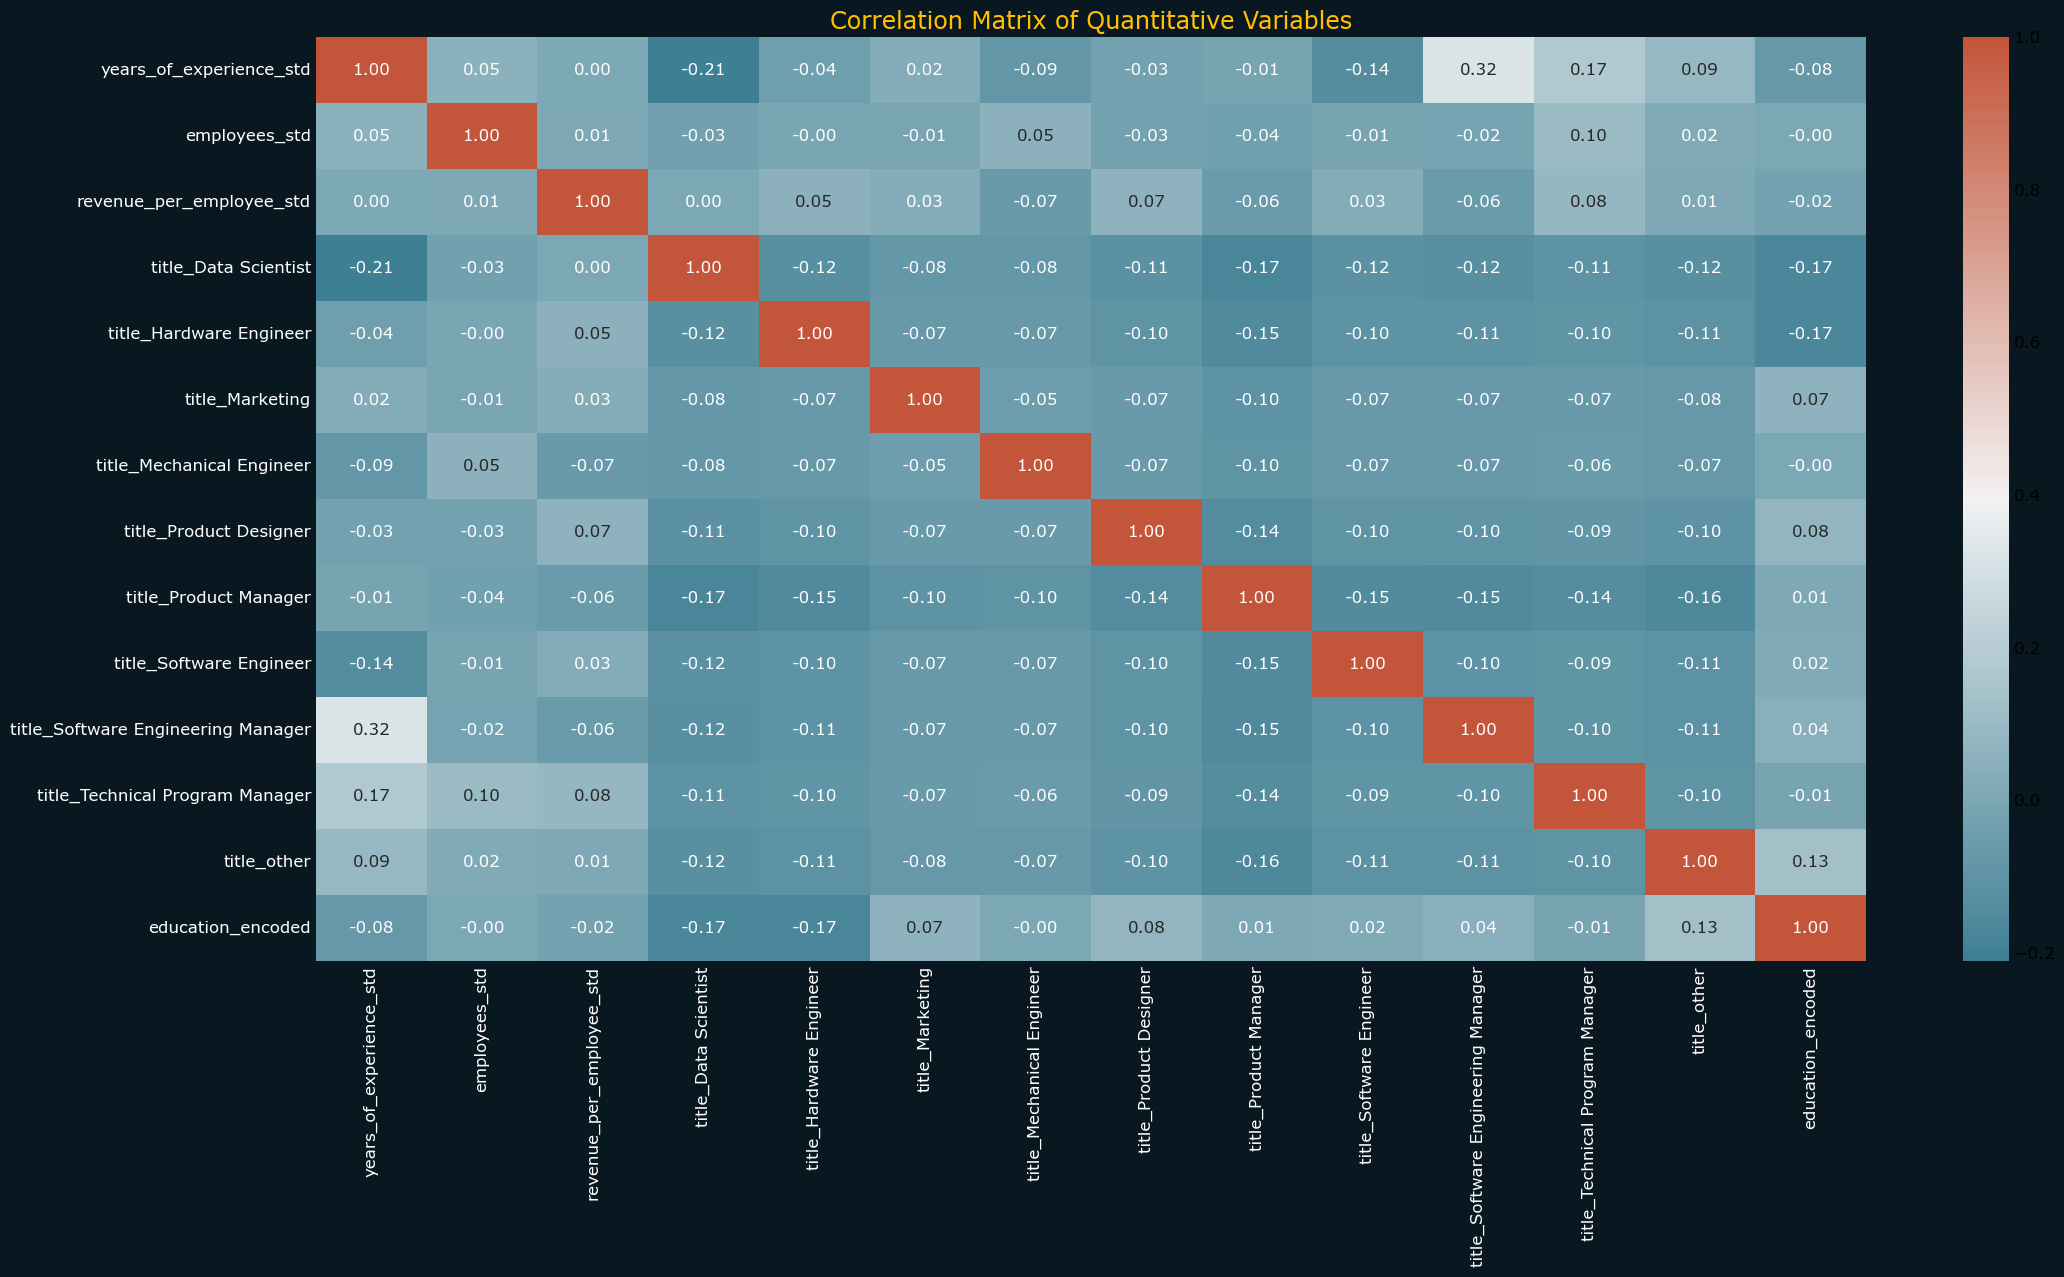

In [436]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Visualize correlation matrix)
plt.figure(figsize=(25, 12), facecolor='#091720')

sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), fmt=".2f")

plt.tick_params(colors='white')
plt.title('Correlation Matrix of Quantitative Variables', color='#FFC000')
plt.show()

plt.show()

# Normality of Residuals

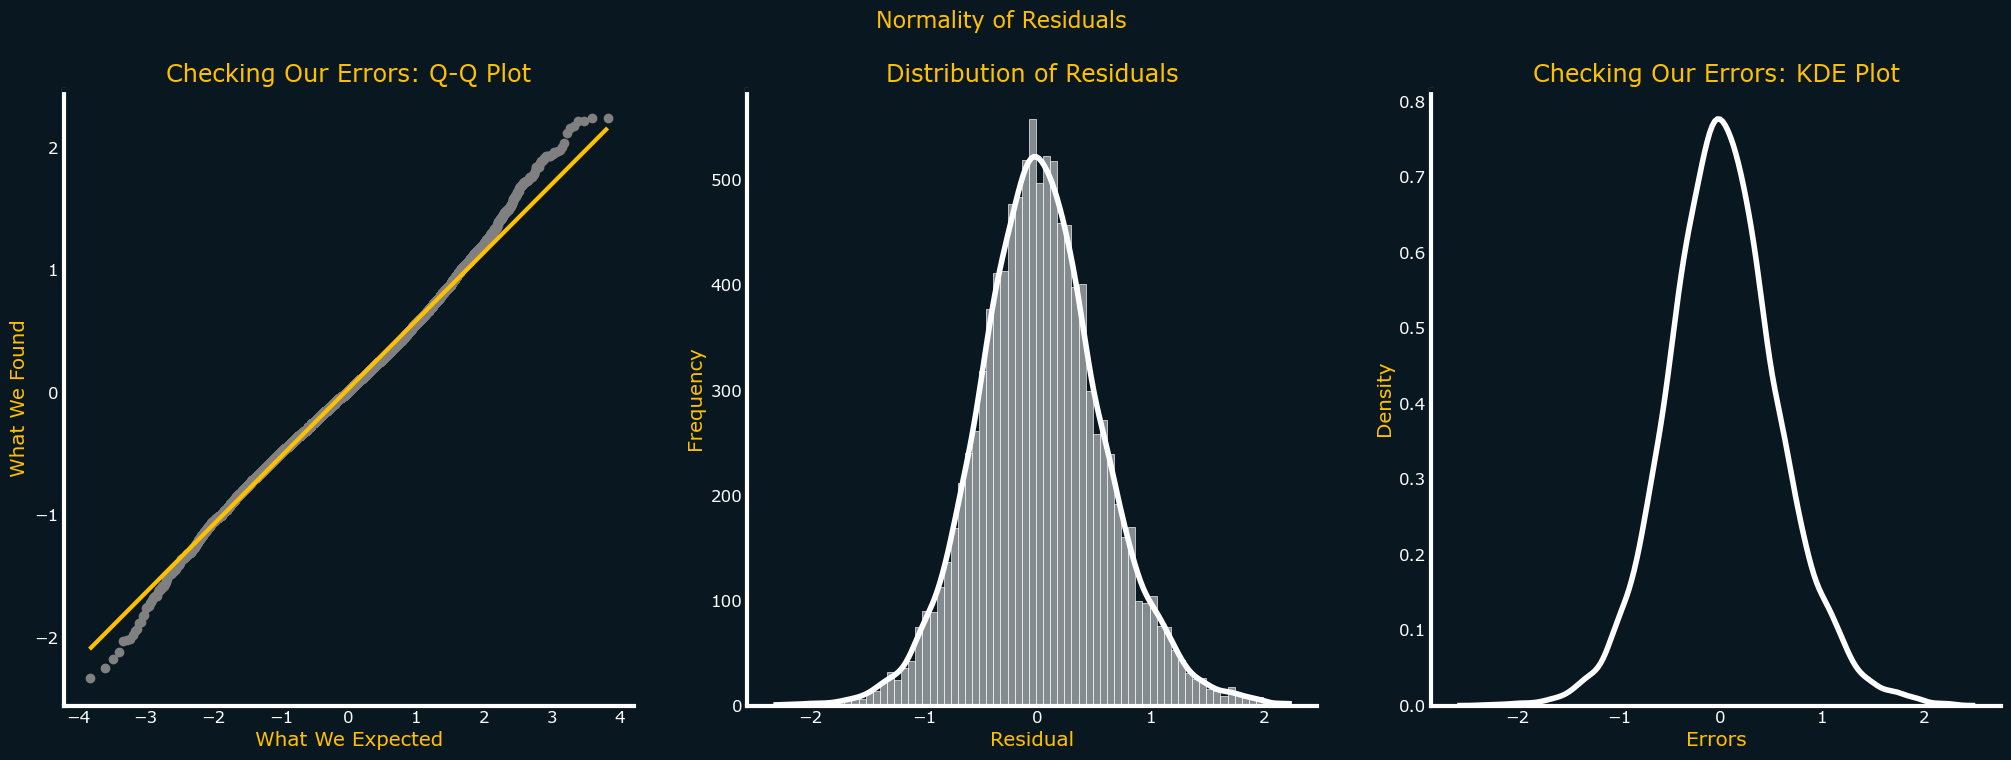

In [437]:
import scipy.stats as stats

y_pred_full = lm.predict(X_full)
residuals_full = y_full - y_pred_full

fig, ax = plt.subplots(ncols=3)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Normality of Residuals', color='#FFC000', fontsize=16)

#Q-Q Plot
stats.probplot(residuals_full, dist="norm", plot=ax[0])
ax[0].set_title('Checking Our Errors: Q-Q Plot', color='#FFC000')
ax[0].set_xlabel('What We Expected', color='#FFC000')
ax[0].set_ylabel('What We Found', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')

ax[0].get_lines()[0].set_color('grey')
ax[0].get_lines()[1].set_color('#FFC000')
ax[0].get_lines()[1].set_linewidth(3)

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

# distribution of residuals
sns.histplot(residuals_full, kde=True, ax=ax[1], color='white')
ax[1].set_title('Distribution of Residuals', color='#FFC000')
ax[1].set_xlabel('Residual', color='#FFC000')
ax[1].set_ylabel('Frequency', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

# KDE Plot
sns.kdeplot(residuals_full, ax=ax[2], color='white')
ax[2].set_title('Checking Our Errors: KDE Plot', color='#FFC000')
ax[2].set_xlabel('Errors', color='#FFC000')
ax[2].set_ylabel('Density', color='#FFC000')
ax[2].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='x', colors='white')

ax[2].spines['bottom'].set_color('white')
ax[2].spines['top'].set_color('#091720') 
ax[2].spines['right'].set_color('#091720')
ax[2].spines['left'].set_color('white')
ax[2].set_facecolor('#091720')

plt.show()

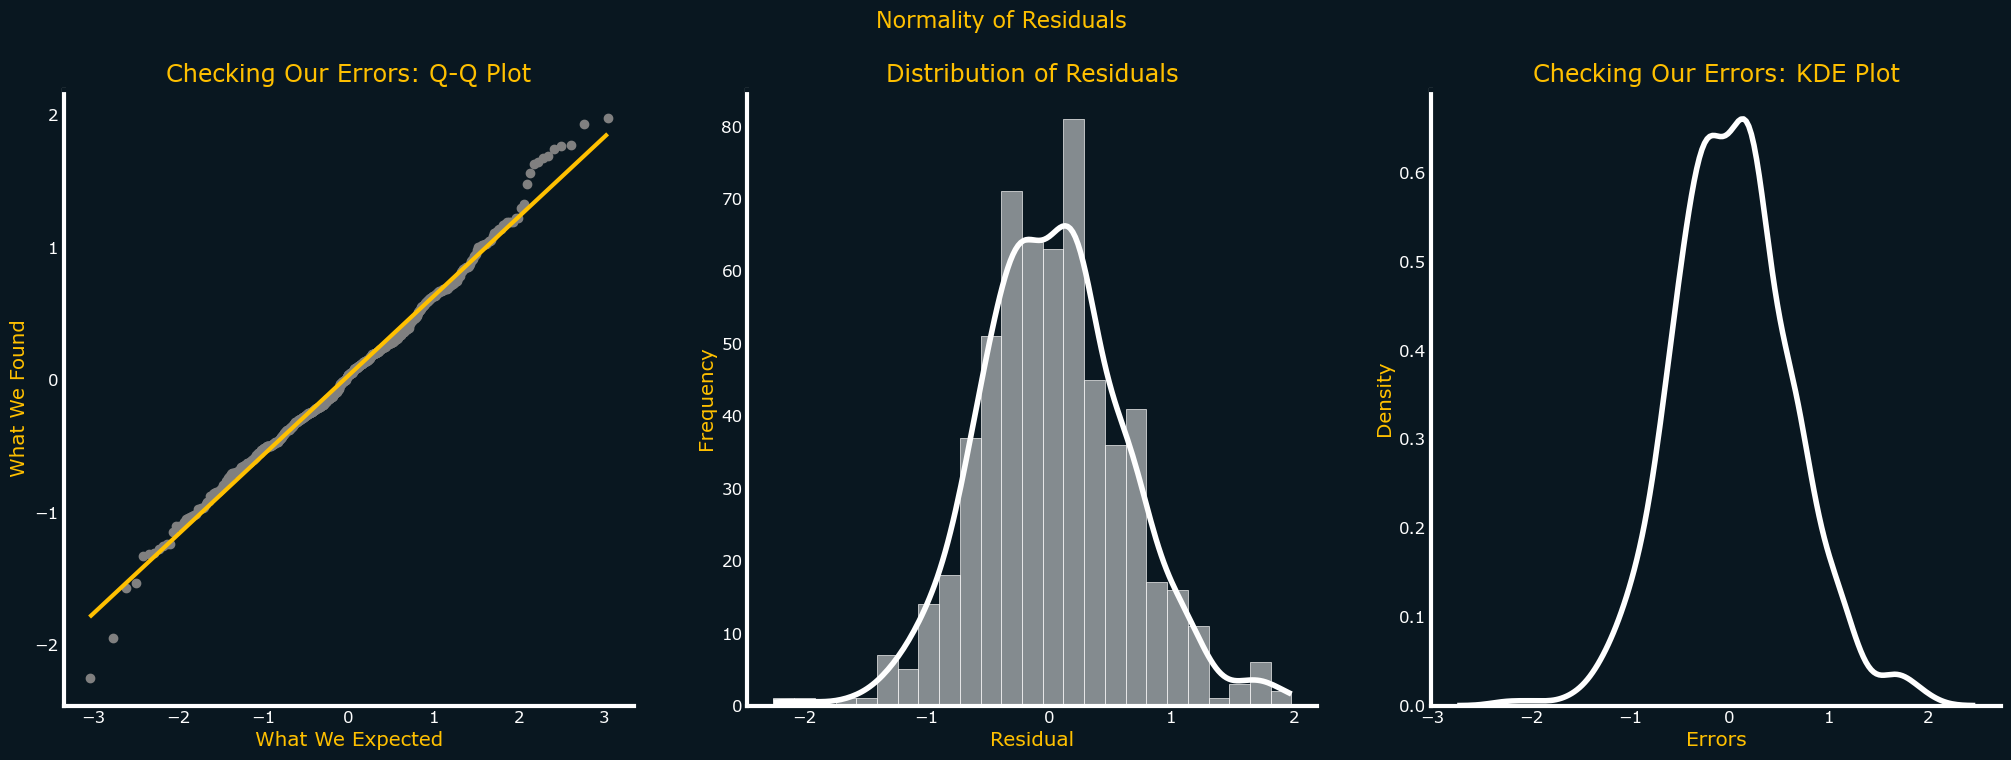

In [438]:
import scipy.stats as stats

residuals = y_test - y_pred

fig, ax = plt.subplots(ncols=3)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Normality of Residuals', color='#FFC000', fontsize=16)

#Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax[0])
ax[0].set_title('Checking Our Errors: Q-Q Plot', color='#FFC000')
ax[0].set_xlabel('What We Expected', color='#FFC000')
ax[0].set_ylabel('What We Found', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')

ax[0].get_lines()[0].set_color('grey')
ax[0].get_lines()[1].set_color('#FFC000')
ax[0].get_lines()[1].set_linewidth(3)

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

# distribution of residuals
sns.histplot(residuals, kde=True, ax=ax[1], color='white')
ax[1].set_title('Distribution of Residuals', color='#FFC000')
ax[1].set_xlabel('Residual', color='#FFC000')
ax[1].set_ylabel('Frequency', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

# KDE Plot
sns.kdeplot(residuals, ax=ax[2], color='white')
ax[2].set_title('Checking Our Errors: KDE Plot', color='#FFC000')
ax[2].set_xlabel('Errors', color='#FFC000')
ax[2].set_ylabel('Density', color='#FFC000')
ax[2].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='x', colors='white')

ax[2].spines['bottom'].set_color('white')
ax[2].spines['top'].set_color('#091720') 
ax[2].spines['right'].set_color('#091720')
ax[2].spines['left'].set_color('white')
ax[2].set_facecolor('#091720')

plt.show()

# Homoscedasticity

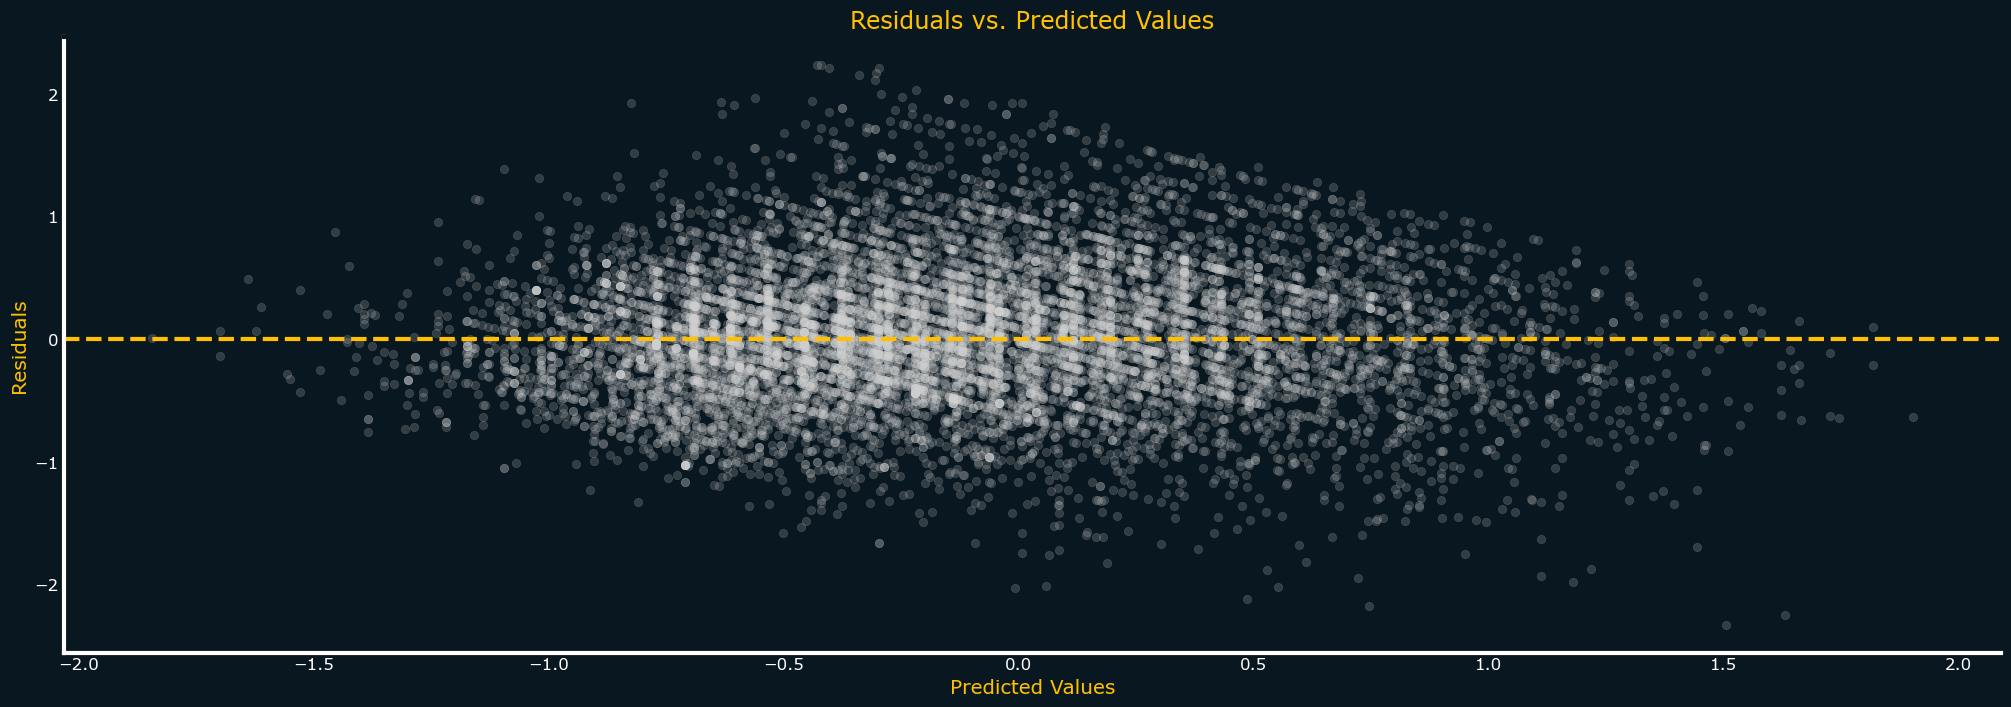

In [439]:
#Residual Plot
plt.figure(figsize=(25, 8))
plt.scatter(y_pred_full, residuals_full, alpha=0.2, color='lightgrey')
plt.axhline(y=0, color='#FFC000', linestyle='--', linewidth=3)
plt.xlabel('Predicted Values', color='#FFC000')
plt.ylabel('Residuals', color='#FFC000')
plt.tick_params(axis='y', colors='white')
plt.tick_params(axis='x', colors='white')
plt.title('Residuals vs. Predicted Values', color='#FFC000')

plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('#091720') 
plt.gca().spines['right'].set_color('#091720')
plt.gca().spines['left'].set_color('white')
plt.gca().set_facecolor('#091720')
plt.gcf().set_facecolor('#091720')

plt.show()

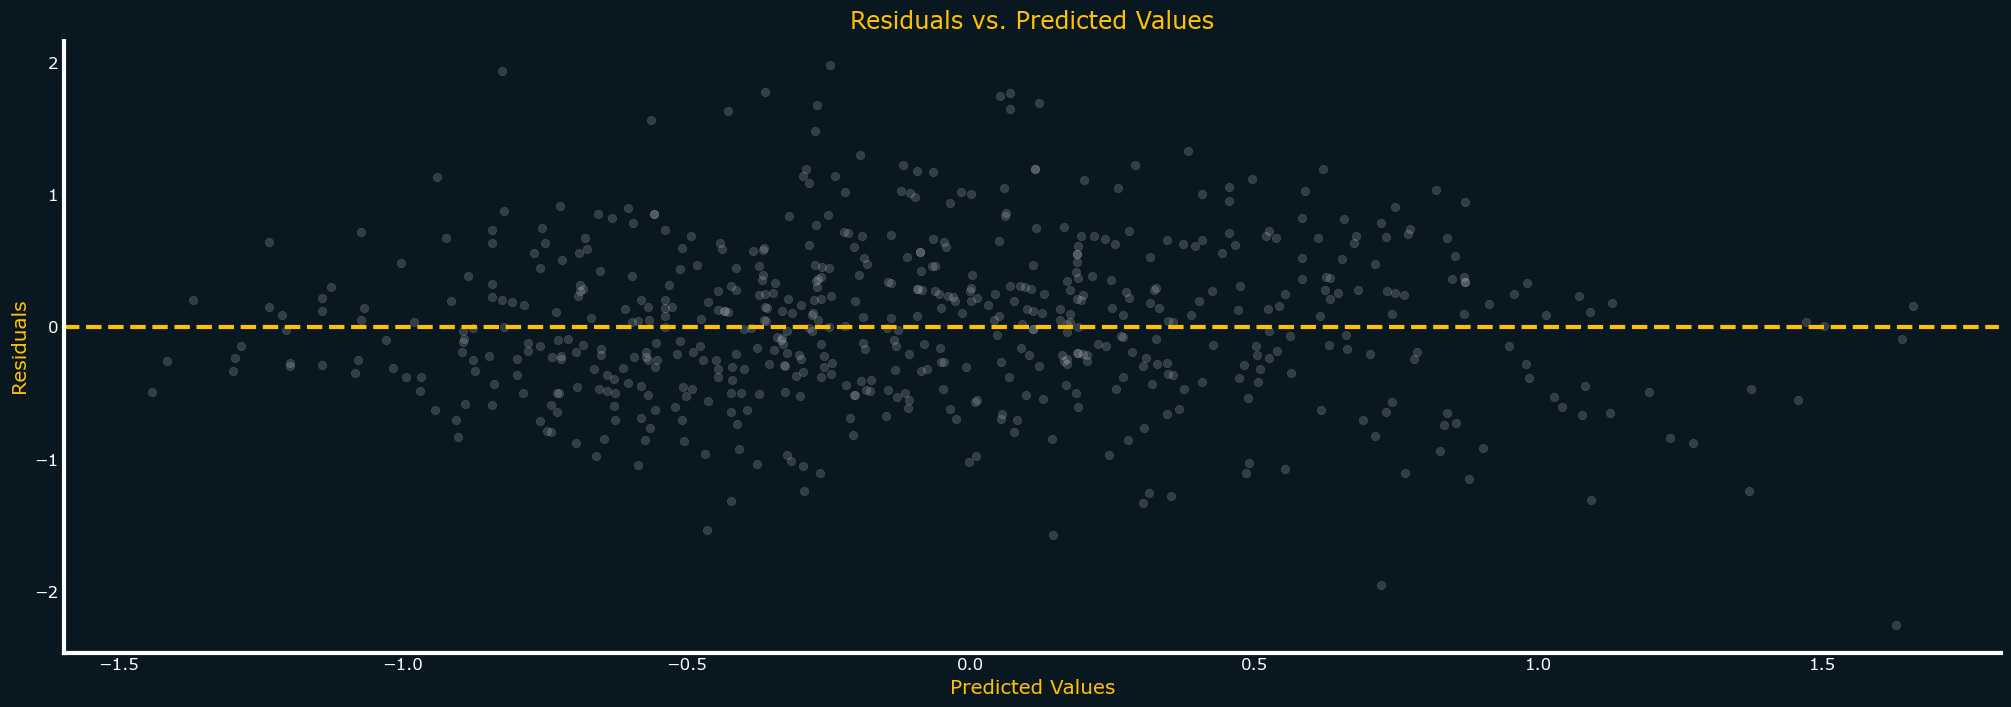

In [440]:
#Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(25, 8))
plt.scatter(y_pred, residuals, alpha=0.2, color='lightgrey')
plt.axhline(y=0, color='#FFC000', linestyle='--', linewidth=3)
plt.xlabel('Predicted Values', color='#FFC000')
plt.ylabel('Residuals', color='#FFC000')
plt.tick_params(axis='y', colors='white')
plt.tick_params(axis='x', colors='white')
plt.title('Residuals vs. Predicted Values', color='#FFC000')

plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('#091720') 
plt.gca().spines['right'].set_color('#091720')
plt.gca().spines['left'].set_color('white')
plt.gca().set_facecolor('#091720')
plt.gcf().set_facecolor('#091720')

plt.show()

# Independence

In [441]:
print("Avg. Durbin-Watson statistic: " , format(lm.durb_wat_mean, '.3f'))

Avg. Durbin-Watson statistic:  1.963


In [442]:
X.shape

(2962, 14)

In [443]:
y.shape

(2962,)

# Decision Tree Modeling & Comparison

In [448]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X, y)

# Predict on the full data
dt_pred = dt_model.predict(X_full_no_const)

# Calculate evaluation metrics
dt_mse = mean_squared_error(y_full, dt_pred)
dt_r2 = r2_score(y_full, dt_pred)

# Print the results
print('MSE: {:.3f}'.format(dt_mse))
print('r^2: {:.3f}'.format(dt_r2))

MSE: 0.372
r^2: 0.362


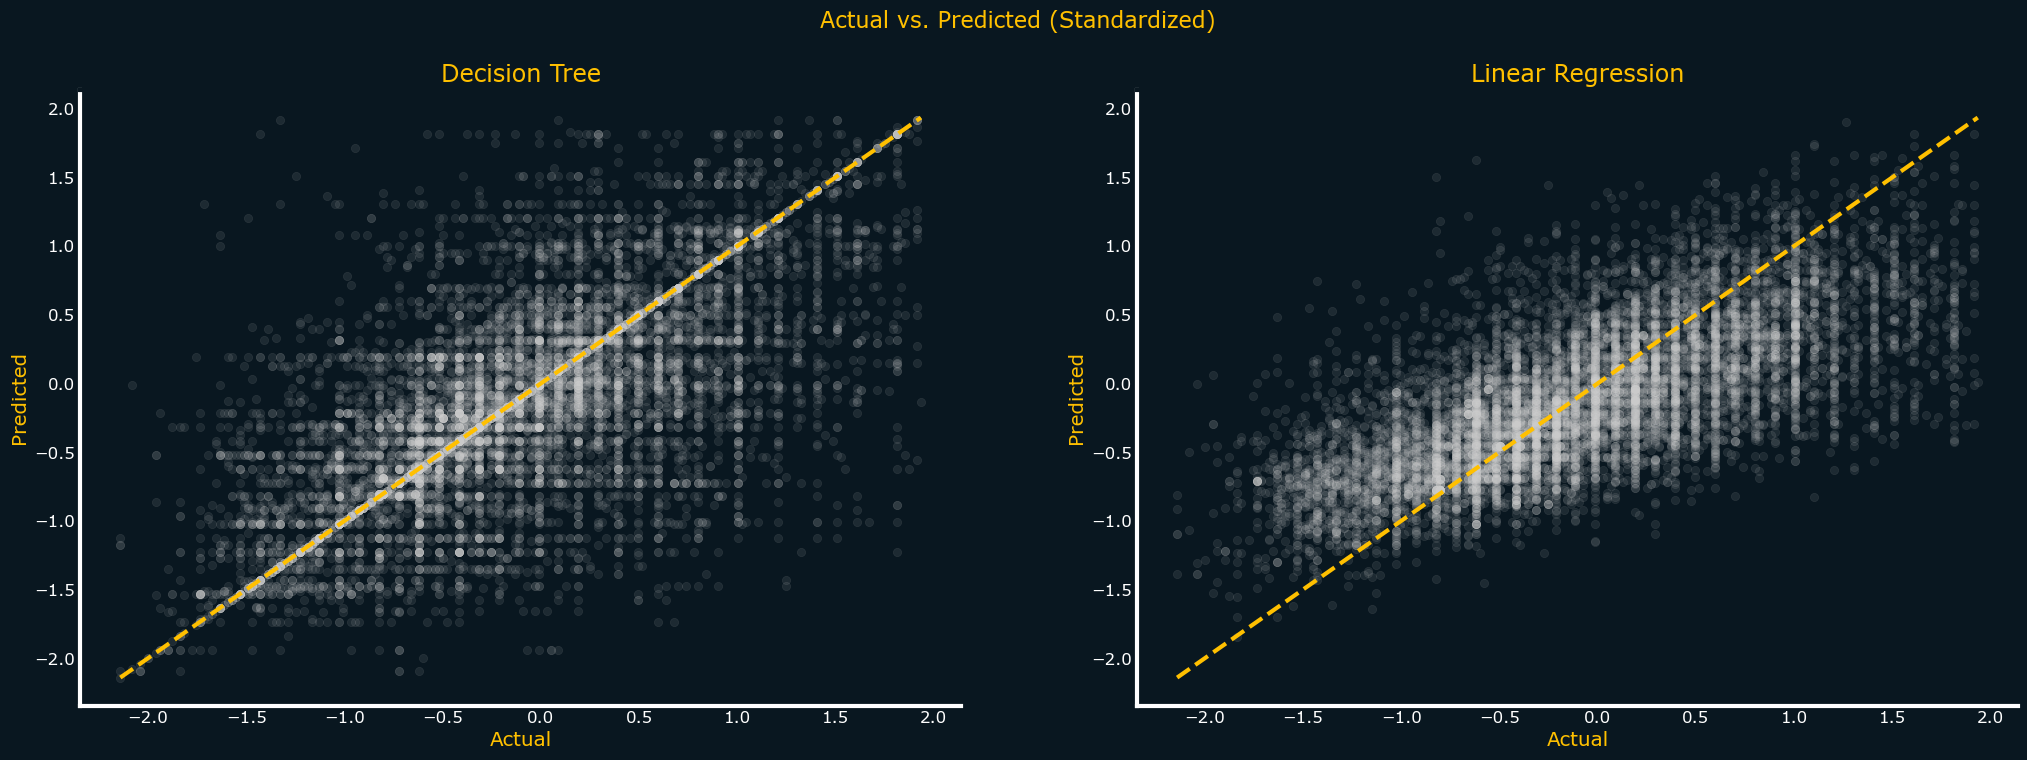

In [450]:
# plot actual vs. predicted of both models
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Actual vs. Predicted (Standardized)', color='#FFC000', fontsize=16)

plt.sca(ax[0])
plt.scatter(y_full, dt_pred, color='lightgrey', label='Decision Tree', alpha=.1)
plt.plot([min(y_full), max(y_full)], [min(y_full), max(y_full)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Decision Tree', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

plt.sca(ax[1])
plt.scatter(y_full, y_pred_full, color='lightgray', label='Linear Regression', alpha=.1)
plt.plot([min(y_full), max(y_full)], [min(y_full), max(y_full)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Linear Regression', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

plt.show()

In [451]:
param_grid = {'min_samples_split': [5, 10, 60, 300],
              'min_samples_leaf' : [3, 5, 10],
              'max_depth': [None, 5, 10, 15, 20, 25],
              'max_features': [None, 'sqrt', 13, 11, 9, 7, 5],
              'criterion' : ['friedman_mse', 'squared_error', 'absolute_error'],
              'max_leaf_nodes': [750, 500, 250],
              'random_state': [42]}

dt_model = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

dt_params = grid_search.best_params_
print("Best Parameters: ", dt_params)

Best Parameters:  {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 9, 'max_leaf_nodes': 750, 'min_samples_leaf': 5, 'min_samples_split': 60, 'random_state': 42}


In [455]:
best_estimator = grid_search.best_estimator_

# Predict on the full data
dt_pred = best_estimator.predict(X_full_no_const)

# Calculate evaluation metrics
dt_mse = mean_squared_error(y_full, dt_pred)
dt_r2 = r2_score(y_full, dt_pred)

# Print the results
print('MSE: {:.3f}'.format(dt_mse))
print('r^2: {:.3f}'.format(dt_r2))

MSE: 0.322
r^2: 0.448


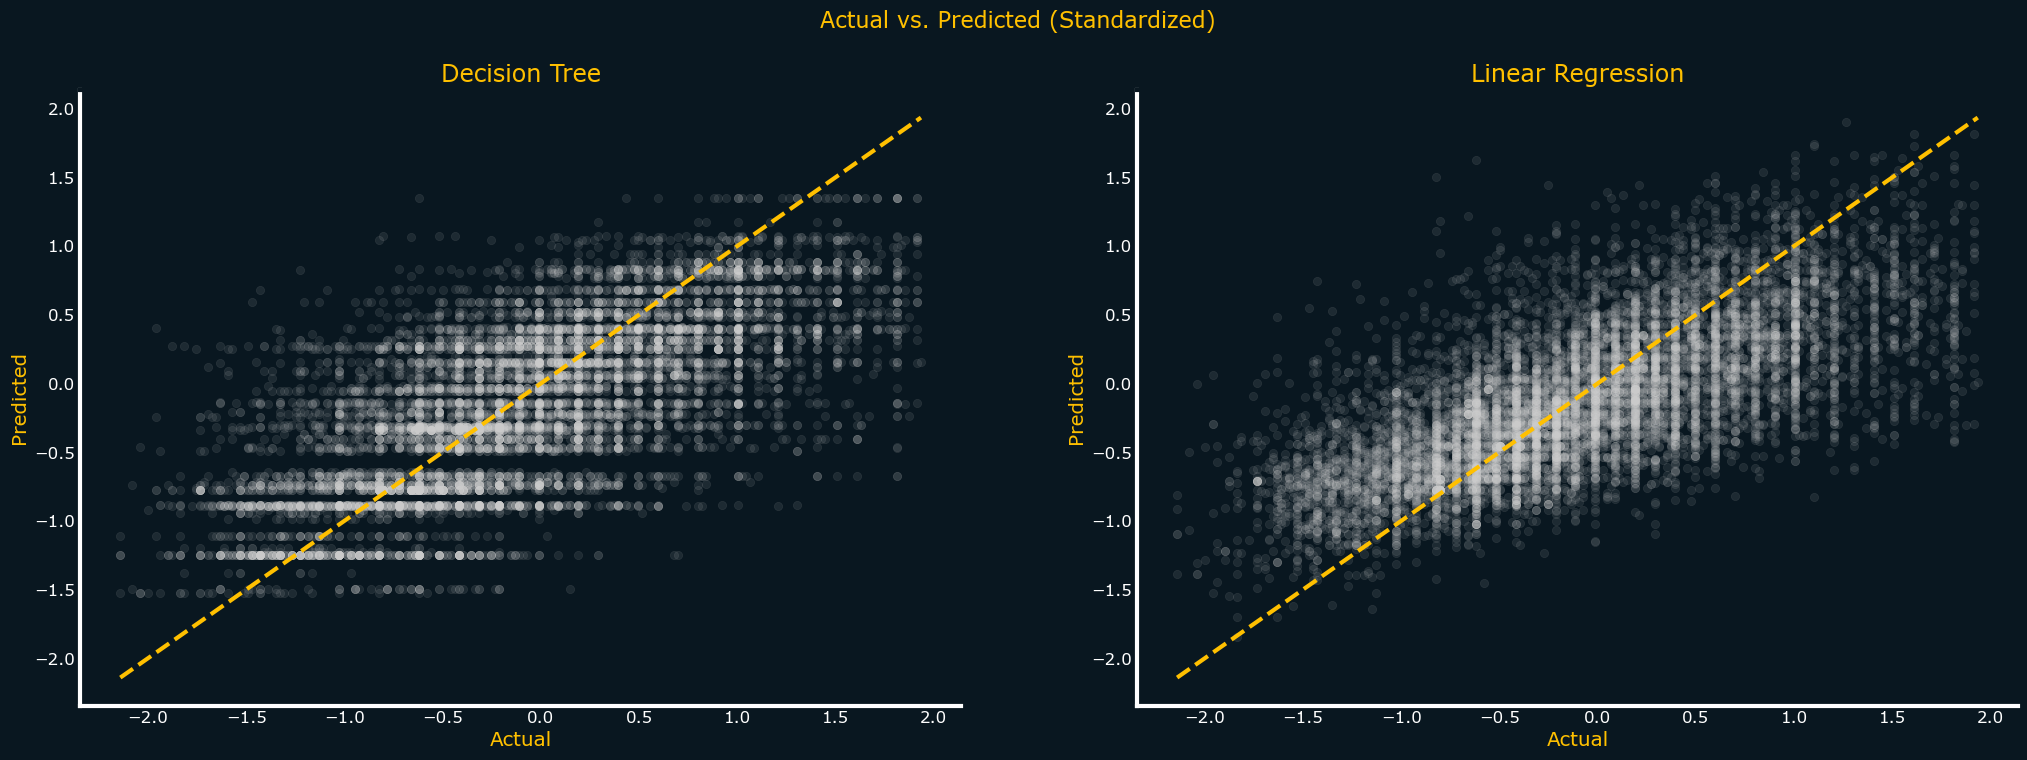

In [456]:
# plot actual vs. predicted of both models
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Actual vs. Predicted (Standardized)', color='#FFC000', fontsize=16)

plt.sca(ax[0])
plt.scatter(y_full, dt_pred_full, color='lightgrey', label='Decision Tree', alpha=.1)
plt.plot([min(y_full), max(y_full)], [min(y_full), max(y_full)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Decision Tree', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

plt.sca(ax[1])
plt.scatter(y_full, y_pred_full, color='lightgray', label='Linear Regression', alpha=.1)
plt.plot([min(y_full), max(y_full)], [min(y_full), max(y_full)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Linear Regression', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

plt.show()

In [464]:
param_grid = {'min_samples_split': [45, 60, 250],
              'min_samples_leaf' : [4, 5, 8],
              'max_depth': [10, 15],
              'max_features': [None, 13, 11, 9, 8],
              'criterion' : ['friedman_mse', 'squared_error'],
              'max_leaf_nodes': [2500, 2000, 1500],
              'random_state': [42]}

dt_model = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

dt_params = grid_search.best_params_
print("Best Parameters: ", dt_params)

Best Parameters:  {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 9, 'max_leaf_nodes': 2500, 'min_samples_leaf': 5, 'min_samples_split': 60, 'random_state': 42}


In [465]:
best_estimator = grid_search.best_estimator_

# Predict on the full data
dt_pred = best_estimator.predict(X_full_no_const)

# Calculate evaluation metrics
dt_mse = mean_squared_error(y_full, dt_pred)
dt_r2 = r2_score(y_full, dt_pred)

# Print the results
print('MSE: {:.3f}'.format(dt_mse))
print('r^2: {:.3f}'.format(dt_r2))

MSE: 0.322
r^2: 0.448


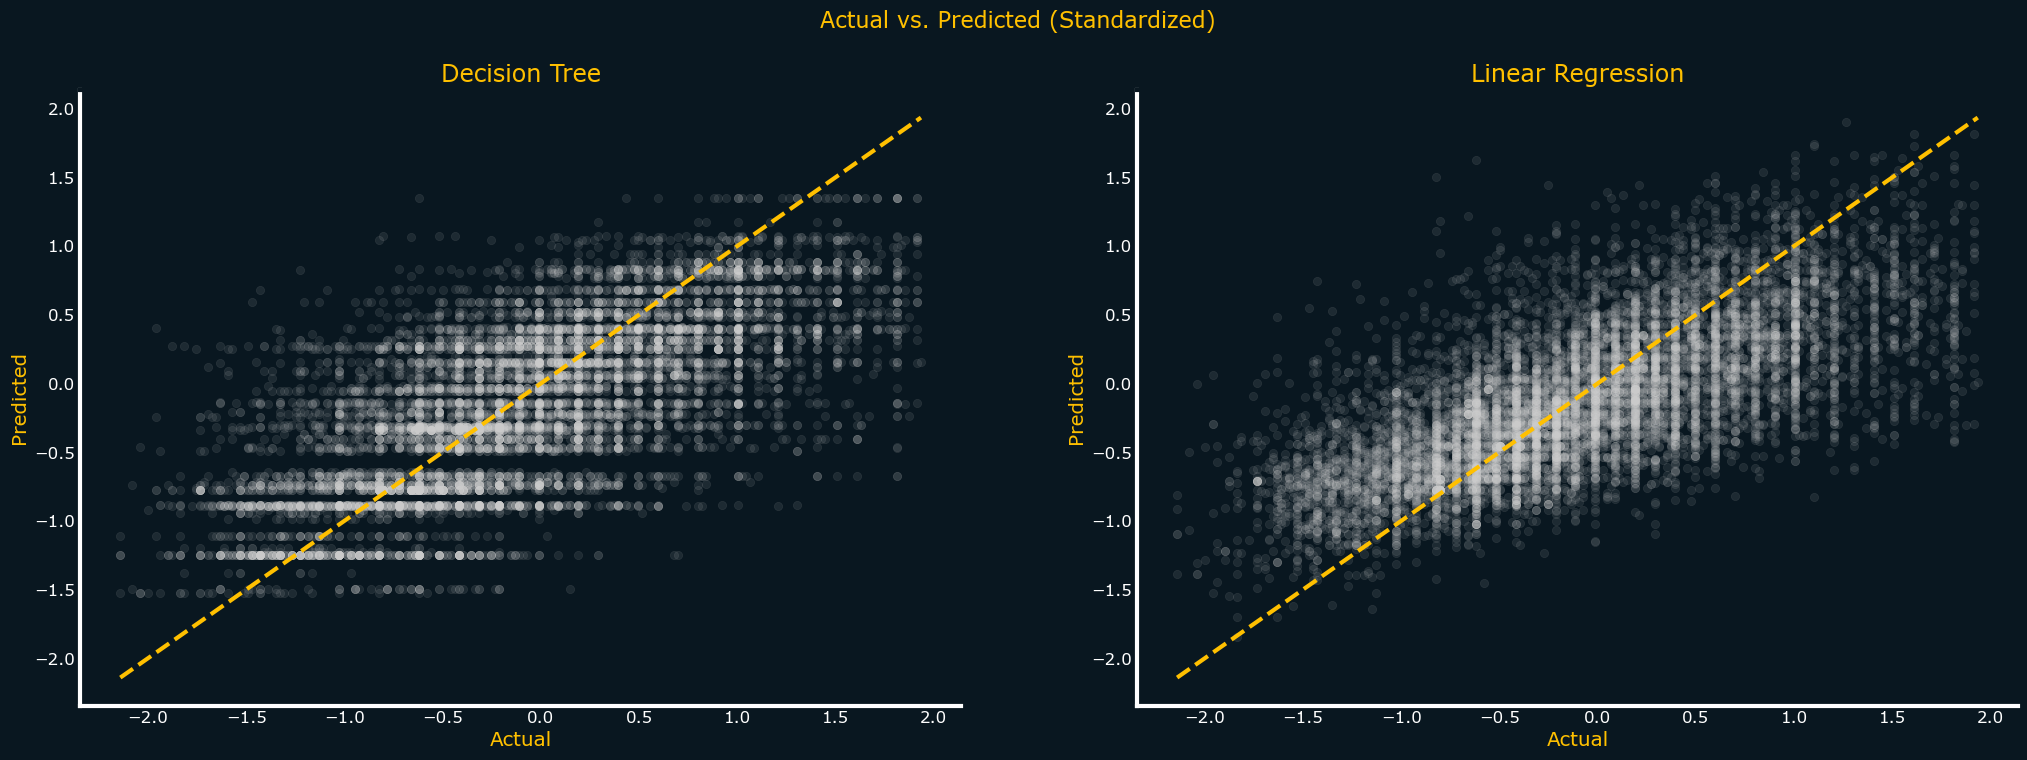

In [466]:
# plot actual vs. predicted of both models
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Actual vs. Predicted (Standardized)', color='#FFC000', fontsize=16)

plt.sca(ax[0])
plt.scatter(y_full, dt_pred_full, color='lightgrey', label='Decision Tree', alpha=.1)
plt.plot([min(y_full), max(y_full)], [min(y_full), max(y_full)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Decision Tree', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

plt.sca(ax[1])
plt.scatter(y_full, y_pred_full, color='lightgray', label='Linear Regression', alpha=.1)
plt.plot([min(y_full), max(y_full)], [min(y_full), max(y_full)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Linear Regression', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

plt.show()

In [ ]:
# plot actual vs. predicted of both models
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Actual vs. Predicted (Standardized)', color='#FFC000', fontsize=16)

plt.sca(ax[0])
plt.scatter(y, dt_predictions, color='lightgrey', label='Decision Tree', alpha=.1)
plt.plot([min(y), max(y)], [min(y), max(y)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Decision Tree', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

plt.sca(ax[1])
plt.scatter(y_test, y_pred, color='lightgray', label='Linear Regression', alpha=.1)
plt.plot([min(y), max(y)], [min(y), max(y)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Linear Regression', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

plt.show()

In [ ]:
y_test.shape

In [ ]:
#unstandardizing the data
mean = public_companies['base_salary'].mean()
std = public_companies['base_salary'].std()

unstandardized_predictions = (y_pred * std) + mean
unstandardized_test        = (y_test * std) + mean
unstandardized_dt_predictions = (dt_predictions * std) + mean

In [ ]:
# plot actual vs. predicted of both models
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Actual vs. Predicted (Unstandardized)', color='#FFC000', fontsize=16)

plt.sca(ax[0])
plt.scatter(unstandardized_test, unstandardized_dt_predictions, color='lightgrey', label='Decision Tree', alpha=.1)
plt.plot([min(unstandardized_test), max(unstandardized_test)], [min(unstandardized_test), max(unstandardized_test)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Decision Tree', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

plt.sca(ax[1])
plt.scatter(unstandardized_test, unstandardized_predictions, color='lightgrey', label='Linear Regression', alpha=.1)
plt.plot([min(unstandardized_test), max(unstandardized_test)], [min(unstandardized_test), max(unstandardized_test)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Linear Regression', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

plt.show()

In [ ]:
print("Decision Tree - MSE: ", dt_mse)
print("Decision Tree - MAE: ", dt_mae)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

# Gradient Descent, Because Why Not?

In [ ]:
import lab_utils_multi
from lab_utils_multi import  run_gradient_descent
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w
from lab_utils_common import dlc

In [ ]:
X_train_gd = X_train_final.drop(columns=['const']).values
y_train_gd = np.array(y_train)
X_test_gd = X_test_final.drop(columns=['const']).values
y_test_gd  = np.array(y_test)
X_features = X_train_final.drop(columns=['const']).columns.values


In [ ]:
b_init = np.array([0.0])
w_init = np.zeros(X_train_gd.shape[1])

In [ ]:
w_norm, b_norm, hist = run_gradient_descent(X_train_gd, y_train_gd, 1000, 1.0e-1, )

In [ ]:
m = X_train_gd.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_train_gd[i], w_norm) + b_norm

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,3,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train_gd[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train_gd[:,i],yp,color=dlc["dlorange"], label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

In [ ]:
y_pred_gd = np.dot(X_test_gd, w_norm) + b_norm
gd_mse = mean_squared_error(y_test_gd, y_pred_gd)
gd_mae = mean_absolute_error(y_test_gd, y_pred_gd)
gd_r2 = r2_score(y_test_gd, y_pred_gd)
gd_ar2 = adj_r2_score(X_test_gd, y_test_gd, y_pred_gd)

In [ ]:
print('Gradient Descent    MSE: ' + str(gd_mse.round(2)))
print('                    MAE: ' + str(gd_mae.round(2)))
print('                    r^2: ' + str(gd_r2.round(2)))
print('                   ar^2: ' + str(gd_ar2.round(2)))
print("Decision Tree       MSE: " + str(dt_mse.round(2)))
print("                    MAE: " + str(dt_mae.round(2)))
print('                    r^2: ' + str(dt_r2.round(2)))      
print('                   ar^2: ' + str(dt_ar2.round(2)))      
print("Linear Regression   MSE: " + str(lr_mse.round(2)))
print("                    MAE: " + str(lr_mae.round(2)))
print('                    r^2: ' + str(lr_r2.round(2)))
print('                   ar^2: ' + str(lr_ar2.round(2)))

In [ ]:
w_norm, b_norm, hist = run_gradient_descent(X_train_gd, y_train_gd, 3000, 9.0e-2, )

In [ ]:
m = X_train_gd.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_train_gd[i], w_norm) + b_norm

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,3,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train_gd[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train_gd[:,i],yp,color=dlc["dlorange"], label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

In [ ]:
y_pred_gd = np.dot(X_test_gd, w_norm) + b_norm
gd_mse = mean_squared_error(y_test_gd, y_pred_gd)
gd_mae = mean_absolute_error(y_test_gd, y_pred_gd)
gd_r2 = r2_score(y_test_gd, y_pred_gd)
gd_ar2 = adj_r2_score(X_test_gd, y_test_gd, y_pred_gd)

In [ ]:
print('Gradient Descent    MSE: ' + str(gd_mse.round(2)))
print('                    MAE: ' + str(gd_mae.round(2)))
print('                    r^2: ' + str(gd_r2.round(2)))
print('                   ar^2: ' + str(gd_ar2.round(2)))
print("Decision Tree       MSE: " + str(dt_mse.round(2)))
print("                    MAE: " + str(dt_mae.round(2)))
print('                    r^2: ' + str(dt_r2.round(2)))      
print('                   ar^2: ' + str(dt_ar2.round(2)))      
print("Linear Regression   MSE: " + str(lr_mse.round(2)))
print("                    MAE: " + str(lr_mae.round(2)))
print('                    r^2: ' + str(lr_r2.round(2)))
print('                   ar^2: ' + str(lr_ar2.round(2)))